# Customer Analytics for Online Retailer

We are given a dataset which contains all transactions for a Europe-based and registered non-store online retailer. The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers. The objective of this exercise is to build recommendations to facilitate the retailer's customers’ future purchases by identifying sets of items that can be offered as bundles.

The exercise will cover a few areas:
1. Data Prepration
2. Exploratory Data Analysis
3. Customer Segmentation
4. Market Basket Analysis

# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotnine
from plotnine import *

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
trans = pd.read_csv("data/dataset.csv")

In [3]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433527 entries, 0 to 433526
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Orderno   433527 non-null  object 
 1   prodcode  433527 non-null  object 
 2   proddesc  432357 non-null  object 
 3   qty       433527 non-null  int64  
 4   date      433527 non-null  object 
 5   uprice    433527 non-null  float64
 6   custid    325290 non-null  float64
 7   country   433527 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.5+ MB


We note that there are a total of 433527 observations, and many missing values in custid.

In [4]:
trans.describe()

qty         uprice         custid
count  433527.000000  433527.000000  325290.000000
mean        9.582148       4.660611   15288.354889
std       176.010575      96.904838    1713.731765
min    -74215.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13954.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

There are negative values in the quantity and unit price, which is unusual. We will look into these further.

# Data Preparation

## Data Cleaning for individual line items

### Convert data format

In [5]:
# convert date to proper format
trans["date"] = pd.to_datetime(trans["date"], format="%d/%m/%y %H:%M")

# convert custid to int
trans["custid"] = trans["custid"].astype("Int64")

### Remove duplicates

In [6]:
# Check duplicates
trans[trans.duplicated(keep = False)].sort_values(["Orderno", "prodcode"]).head(2)

Orderno prodcode                     proddesc  qty                date   
6948    536409    21866  UNION JACK FLAG LUGGAGE TAG    1 2010-12-01 11:45:00  \
248867  536409    21866  UNION JACK FLAG LUGGAGE TAG    1 2010-12-01 11:45:00   

        uprice  custid         country  
6948      1.25   17908  United Kingdom  
248867    1.25   17908  United Kingdom

In [7]:
# Check number of duplicates
trans.duplicated().sum()

3458

In [8]:
# Drop duplicates
trans = trans.drop_duplicates(keep = "first")

### Compute total price column per row

In [9]:
# compute total price per row
trans.loc[:,"tprice"] = trans["qty"] * trans["uprice"]
trans.head()

Orderno prodcode                             proddesc  qty   
0  574856    22649         STRAWBERRY FAIRY CAKE TEAPOT    1  \
1  581219    10135         COLOURING PENCILS BROWN TUBE    1   
2  561485    47566                        PARTY BUNTING    2   
3  571508    23085         ANTIQUE SILVER BAUBLE LAMP      1   
4  541262    21464  DISCO BALL ROTATOR BATTERY OPERATED    1   

                 date  uprice  custid         country  tprice  
0 2011-11-07 12:06:00   10.79    <NA>  United Kingdom   10.79  
1 2011-12-08 09:28:00    2.46    <NA>  United Kingdom    2.46  
2 2011-07-27 13:42:00    4.95   17841  United Kingdom    9.90  
3 2011-10-17 15:27:00   20.79    <NA>  United Kingdom   20.79  
4 2011-01-16 15:50:00    4.25   18069  United Kingdom    4.25

### Clean up product codes

There are some prodcodes which are not the usual, like Manual, DOT. The usual prodcode is noted to consist of digits and for this purpose, we will remove those that are not made up of digits.

In [10]:
# check prodcode
trans[~trans["prodcode"].str[0].str.isdigit()].head()

Orderno prodcode        proddesc  qty                date  uprice   
246   571465        M          Manual    1 2011-10-17 14:29:00    0.85  \
333  C548830        M          Manual   -1 2011-04-04 13:08:00  239.30   
345   544766      DOT  DOTCOM POSTAGE    1 2011-02-23 11:09:00  136.38   
414   543097      DOT  DOTCOM POSTAGE    1 2011-02-03 11:41:00  168.53   
422   554305        M          Manual    1 2011-05-23 14:58:00  557.72   

     custid         country  tprice  
246   14830  United Kingdom    0.85  
333   12744       Singapore -239.30  
345    <NA>  United Kingdom  136.38  
414    <NA>  United Kingdom  168.53  
422   12757        Portugal  557.72

In [11]:
# remove transactions with irregular product codes
trans = trans[trans["prodcode"].str[0].str.isdigit()]

# change prodcode to upper case for consistency
trans.loc[:,"prodcode"] = trans.loc[:,"prodcode"].str.upper()

# extract only the numbers from prodcode as the alphabet at the back refers to the different designs
trans.loc[:,"prodcode_num"] = trans.loc[:,"prodcode"].str[:5].astype("Int64")

trans.head()

Orderno prodcode                             proddesc  qty   
0  574856    22649         STRAWBERRY FAIRY CAKE TEAPOT    1  \
1  581219    10135         COLOURING PENCILS BROWN TUBE    1   
2  561485    47566                        PARTY BUNTING    2   
3  571508    23085         ANTIQUE SILVER BAUBLE LAMP      1   
4  541262    21464  DISCO BALL ROTATOR BATTERY OPERATED    1   

                 date  uprice  custid         country  tprice  prodcode_num  
0 2011-11-07 12:06:00   10.79    <NA>  United Kingdom   10.79         22649  
1 2011-12-08 09:28:00    2.46    <NA>  United Kingdom    2.46         10135  
2 2011-07-27 13:42:00    4.95   17841  United Kingdom    9.90         47566  
3 2011-10-17 15:27:00   20.79    <NA>  United Kingdom   20.79         23085  
4 2011-01-16 15:50:00    4.25   18069  United Kingdom    4.25         21464

In [12]:
# Change all proddesc to caps
trans["proddesc"] = trans["proddesc"].str.upper()

### Remove all empty custid

There are 107308 transactions where customer id is null. We will remove these cases from the dataset as our objective to to conduct analysis on the customers.

In [13]:
trans["custid"].isnull().sum()

107308

In [14]:
cleaned = trans.dropna(subset="custid")
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320337 entries, 2 to 433526
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Orderno       320337 non-null  object        
 1   prodcode      320337 non-null  object        
 2   proddesc      320337 non-null  object        
 3   qty           320337 non-null  int64         
 4   date          320337 non-null  datetime64[ns]
 5   uprice        320337 non-null  float64       
 6   custid        320337 non-null  Int64         
 7   country       320337 non-null  object        
 8   tprice        320337 non-null  float64       
 9   prodcode_num  320337 non-null  Int64         
dtypes: Int64(2), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.5+ MB


### Check negative qty and tprice

In [15]:
cleaned[(cleaned["uprice"] < 0) & (~cleaned["Orderno"].str.startswith("C"))]

Empty DataFrame
Columns: [Orderno, prodcode, proddesc, qty, date, uprice, custid, country, tprice, prodcode_num]
Index: []

In [16]:
cleaned[(cleaned["qty"] < 0) & (~cleaned["Orderno"].str.startswith("C"))]

Empty DataFrame
Columns: [Orderno, prodcode, proddesc, qty, date, uprice, custid, country, tprice, prodcode_num]
Index: []

In [17]:
cleaned[(~cleaned["Orderno"].str.startswith("C")) & (~cleaned["Orderno"].str[0].str.isdigit())]

Empty DataFrame
Columns: [Orderno, prodcode, proddesc, qty, date, uprice, custid, country, tprice, prodcode_num]
Index: []

We note that all the negative qty and prices belongs to orderno starting with C, likely referring to the cancelled orders. All other Orderno begins begin with digits. We can extract the cancelled out separately for analysis.

## Aggregate by Order level

In [18]:
# extract basic order info and remove duplicates
orderinfo = cleaned.drop_duplicates(subset=["Orderno"], keep="first")[["Orderno","date","custid","country"]]
orderinfo.head()

Orderno                date  custid         country
2  561485 2011-07-27 13:42:00   17841  United Kingdom
4  541262 2011-01-16 15:50:00   18069  United Kingdom
5  579792 2011-11-30 15:43:00   12714          France
6  579067 2011-11-28 10:31:00   14470  United Kingdom
7  566304 2011-09-12 09:03:00   18158  United Kingdom

In [19]:
# aggregate the remainder of the columns accordingly
orderagginfo = cleaned.groupby("Orderno", as_index = False).agg({"prodcode_num": lambda x: x.nunique(),
                                                                 "qty": "sum",
                                                                 "tprice": "sum"})
orderagginfo.head()

Orderno  prodcode_num  qty  tprice
0  536365             6   40  139.12
1  536366             2   12   22.20
2  536367             8   63  192.63
3  536368             3   12   55.20
4  536369             1    3   17.85

In [20]:
# combine all order info into single table
orders_combined = pd.merge(orderinfo, orderagginfo, how="left", on="Orderno")

# rename columns
orders_combined.columns = ["orderno", "date", "custid", "country", "numuniqueprod", "totalqty", "ordervalue"]

orders_combined.head()

orderno                date  custid         country  numuniqueprod   
0  561485 2011-07-27 13:42:00   17841  United Kingdom             47  \
1  541262 2011-01-16 15:50:00   18069  United Kingdom             59   
2  579792 2011-11-30 15:43:00   12714          France             58   
3  579067 2011-11-28 10:31:00   14470  United Kingdom              7   
4  566304 2011-09-12 09:03:00   18158  United Kingdom             22   

   totalqty  ordervalue  
0       100      224.60  
1       135      245.96  
2       704     1046.42  
3        51      147.75  
4       234      326.80

In [21]:
# add column on recency of order - based on comparison with end of year 2011-12-31
print(f"Last order date in dataset: {orders_combined['date'].max()}")

orders_combined["daysinceorder"] = (pd.to_datetime("2011-12-31") - orders_combined["date"]).dt.days
orders_combined.head()

Last order date in dataset: 2011-12-09 12:50:00


orderno                date  custid         country  numuniqueprod   
0  561485 2011-07-27 13:42:00   17841  United Kingdom             47  \
1  541262 2011-01-16 15:50:00   18069  United Kingdom             59   
2  579792 2011-11-30 15:43:00   12714          France             58   
3  579067 2011-11-28 10:31:00   14470  United Kingdom              7   
4  566304 2011-09-12 09:03:00   18158  United Kingdom             22   

   totalqty  ordervalue  daysinceorder  
0       100      224.60            156  
1       135      245.96            348  
2       704     1046.42             30  
3        51      147.75             32  
4       234      326.80            109

### Add additional features to orders

In [22]:
# Extract year and month of order
orders_combined["ordermonth"] = orders_combined["date"].dt.month
orders_combined["orderdayofweek"] = orders_combined["date"].dt.day_name()
orders_combined['ordermonthyear'] = orders_combined["date"].dt.to_period('M')

In [23]:
orders_combined.head()

orderno                date  custid         country  numuniqueprod   
0  561485 2011-07-27 13:42:00   17841  United Kingdom             47  \
1  541262 2011-01-16 15:50:00   18069  United Kingdom             59   
2  579792 2011-11-30 15:43:00   12714          France             58   
3  579067 2011-11-28 10:31:00   14470  United Kingdom              7   
4  566304 2011-09-12 09:03:00   18158  United Kingdom             22   

   totalqty  ordervalue  daysinceorder  ordermonth orderdayofweek   
0       100      224.60            156           7      Wednesday  \
1       135      245.96            348           1         Sunday   
2       704     1046.42             30          11      Wednesday   
3        51      147.75             32          11         Monday   
4       234      326.80            109           9         Monday   

  ordermonthyear  
0        2011-07  
1        2011-01  
2        2011-11  
3        2011-11  
4        2011-09

## Aggregate by Customer level

In [24]:
# separate into purchases and returns
purchases = orders_combined[~orders_combined["orderno"].str.startswith("C")]
returns = orders_combined[orders_combined["orderno"].str.startswith("C")]

### Aggregate purchase info

In [25]:
# aggregate purchases by customer
purchases_agg = purchases.groupby("custid", as_index=False).agg({"orderno": "count",
                                                                 "date": ["min", "max"],
                                                                 "numuniqueprod" : ["mean", "sum"],
                                                                 "ordervalue" : ["mean", "sum"],
                                                                 "daysinceorder" : "min",
                                                                "totalqty": ["mean", "sum"]})

In [26]:
# rename columns
purchases_agg.columns = ["custid","num_orders", "min_purchase_date", "max_purchase_date",
                         "mean_prod_in_order", "total_prod_ordered", "mean_ordervalue",
                         "total_ordervalue", "daysincelastorder", "meanqtyofprodinorder",
                         "totalqtyofprodinorder"]

In [27]:
purchases_agg.head()

custid  num_orders   min_purchase_date   max_purchase_date   
0   12347           7 2010-12-07 14:57:00 2011-12-07 15:52:00  \
1   12348           4 2010-12-16 19:09:00 2011-09-25 13:13:00   
2   12349           1 2011-11-21 09:51:00 2011-11-21 09:51:00   
3   12350           1 2011-02-02 16:01:00 2011-02-02 16:01:00   
4   12352           7 2011-02-16 12:33:00 2011-11-03 14:37:00   

   mean_prod_in_order  total_prod_ordered  mean_ordervalue  total_ordervalue   
0           21.571429                 151       505.548571           3538.84  \
1                 4.5                  18       315.760000           1263.04   
2                59.0                  59      1200.170000           1200.17   
3                12.0                  12       225.600000            225.60   
4            7.428571                  52       130.591429            914.14   

   daysincelastorder  meanqtyofprodinorder  totalqtyofprodinorder  
0                 23            272.857143                   1910  
1                 96            464.000000                   1856  
2                 39            550.000000                    550  
3                331            156.000000                    156  
4                 57             52.000000                    364

### Aggregate returns info

In [28]:
# aggregate returns by customer
returns_agg = returns.groupby("custid", as_index=False).agg({"orderno": "count",
                                                             "numuniqueprod" : ["mean", "sum"],
                                                             "ordervalue" : ["mean", "sum"],
                                                             "daysinceorder" : "min"})

In [29]:
# rename columns
returns_agg.columns = ["custid","num_returns", "mean_prod_in_return", "total_prod_returned",
                       "mean_returnvalue", "total_returnvalue", "daysincelastreturn"]

In [30]:
returns_agg.head()

custid  num_returns  mean_prod_in_return  total_prod_returned   
0   12346            1                  1.0                    1  \
1   12352            1                  6.0                    6   
2   12359            2                  2.5                    5   
3   12362            3             2.333333                    7   
4   12375            1                  1.0                    1   

   mean_returnvalue  total_returnvalue  daysincelastreturn  
0     -77183.600000          -77183.60                 346  
1       -102.630000            -102.63                 283  
2        -61.050000            -122.10                  28  
3        -22.466667             -67.40                  32  
4         -2.080000              -2.08                  23

### Merge all customer info

In [31]:
# extract basic customer info and remove duplicates
custinfo = orders_combined.drop_duplicates(subset=["custid"], keep="first")[["custid","country"]]
custinfo.head()

custid         country
0   17841  United Kingdom
1   18069  United Kingdom
2   12714          France
3   14470  United Kingdom
4   18158  United Kingdom

In [32]:
custinfo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4347 entries, 0 to 21031
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   custid   4347 non-null   Int64 
 1   country  4347 non-null   object
dtypes: Int64(1), object(1)
memory usage: 106.1+ KB


In [33]:
# merge all cust info into one table
customers = pd.merge(custinfo, purchases_agg, how="left", on="custid")
customers_combined = pd.merge(customers, returns_agg, how="left", on="custid")

### Add additional features to customers

In [34]:
# compute new column to find number of days between purchases
customers_combined["tenure"] = (customers_combined["max_purchase_date"] - customers_combined["min_purchase_date"]).dt.days

In [35]:
# drop the min_purchase_date and max_purchase_date columns
customers_combined = customers_combined.drop(["max_purchase_date","min_purchase_date"], axis=1)

In [36]:
customers_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4347 entries, 0 to 4346
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   custid                 4347 non-null   Int64  
 1   country                4347 non-null   object 
 2   num_orders             4318 non-null   float64
 3   mean_prod_in_order     4318 non-null   Float64
 4   total_prod_ordered     4318 non-null   Int64  
 5   mean_ordervalue        4318 non-null   float64
 6   total_ordervalue       4318 non-null   float64
 7   daysincelastorder      4318 non-null   float64
 8   meanqtyofprodinorder   4318 non-null   float64
 9   totalqtyofprodinorder  4318 non-null   float64
 10  num_returns            1414 non-null   float64
 11  mean_prod_in_return    1414 non-null   Float64
 12  total_prod_returned    1414 non-null   Int64  
 13  mean_returnvalue       1414 non-null   float64
 14  total_returnvalue      1414 non-null   float64
 15  days

In [37]:
# fill na with zeros
customers_combined = customers_combined.fillna(0)

In [38]:
# function to compute purchase rate
def compute_avg_days_between_purchases(row):
    if row["tenure"] != 0:
        return row["tenure"] / row["num_orders"]
    else:
        return 0
        
customers_combined["avg_days_between_purchases"] = customers_combined.apply(compute_avg_days_between_purchases, axis=1)

In [39]:
# compute average prod value
customers_combined["avg_prod_value"] = customers_combined["total_ordervalue"] / customers_combined["total_prod_ordered"]

In [40]:
# remove customers with num_orders is zero (only exist in dataset as they have returns) - their purchases are likely in period not covered
customers_combined = customers_combined[customers_combined["num_orders"] != 0]

In [41]:
customers_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 0 to 4346
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   custid                      4318 non-null   Int64  
 1   country                     4318 non-null   object 
 2   num_orders                  4318 non-null   float64
 3   mean_prod_in_order          4318 non-null   Float64
 4   total_prod_ordered          4318 non-null   Int64  
 5   mean_ordervalue             4318 non-null   float64
 6   total_ordervalue            4318 non-null   float64
 7   daysincelastorder           4318 non-null   float64
 8   meanqtyofprodinorder        4318 non-null   float64
 9   totalqtyofprodinorder       4318 non-null   float64
 10  num_returns                 4318 non-null   float64
 11  mean_prod_in_return         4318 non-null   Float64
 12  total_prod_returned         4318 non-null   Int64  
 13  mean_returnvalue            4318 non-n

In [42]:
customers_combined.head()

custid         country  num_orders  mean_prod_in_order  total_prod_ordered   
0   17841  United Kingdom       120.0                49.9                5988  \
1   18069  United Kingdom         5.0                72.8                 364   
2   12714          France         5.0                43.6                 218   
3   14470  United Kingdom         2.0                17.5                  35   
4   18158  United Kingdom         2.0                15.0                  30   

   mean_ordervalue  total_ordervalue  daysincelastorder  meanqtyofprodinorder   
0       272.165583          32659.87               22.0            150.791667  \
1       335.186000           1675.93               47.0            208.600000   
2       749.054000           3745.27               30.0            522.200000   
3       197.675000            395.35               32.0             82.500000   
4       209.700000            419.40               30.0            157.000000   

   totalqtyofprodinorder  num_returns  mean_prod_in_return   
0                18095.0         43.0             2.465116  \
1                 1043.0          2.0                  1.0   
2                 2611.0          0.0                  0.0   
3                  165.0          0.0                  0.0   
4                  314.0          0.0                  0.0   

   total_prod_returned  mean_returnvalue  total_returnvalue   
0                  106        -12.035814            -517.54  \
1                    2         -7.425000             -14.85   
2                    0          0.000000               0.00   
3                    0          0.000000               0.00   
4                    0          0.000000               0.00   

   daysincelastreturn  tenure  avg_days_between_purchases  avg_prod_value  
0                37.0   371.0                    3.091667         5.45422  
1                47.0   301.0                   60.200000        4.604203  
2                 0.0   285.0                   57.000000       17.180138  
3                 0.0   275.0                  137.500000       11.295714  
4                 0.0    79.0                   39.500000           13.98

In [43]:
test = customers_combined[["custid", "country", "num_orders", "total_ordervalue", "daysincelastorder", "mean_prod_in_order", "meanqtyofprodinorder", "num_returns", "tenure", "avg_days_between_purchases", "avg_prod_value"]]

In [44]:
test.columns = [["custid", "country", "frequency", "monetary", "recency", "mean_prod_in_order", "meanqtyofprodinorder", "num_returns", "tenure", "avg_days_between_purchases", "avg_prod_value"]]


In [45]:
test

custid         country frequency  monetary recency mean_prod_in_order   
0     17841  United Kingdom     120.0  32659.87    22.0               49.9  \
1     18069  United Kingdom       5.0   1675.93    47.0               72.8   
2     12714          France       5.0   3745.27    30.0               43.6   
3     14470  United Kingdom       2.0    395.35    32.0               17.5   
4     18158  United Kingdom       2.0    419.40    30.0               15.0   
...     ...             ...       ...       ...     ...                ...   
4341  13188  United Kingdom       1.0     99.60    32.0                1.0   
4342  15118  United Kingdom       1.0    244.80   155.0                1.0   
4343  17291  United Kingdom       1.0    550.80   329.0                1.0   
4344  17102  United Kingdom       1.0     25.50   282.0                1.0   
4346  14946  United Kingdom       1.0     33.20    35.0                1.0   

     meanqtyofprodinorder num_returns tenure avg_days_between_purchases   
0              150.791667        43.0  371.0                   3.091667  \
1              208.600000         2.0  301.0                  60.200000   
2              522.200000         0.0  285.0                  57.000000   
3               82.500000         0.0  275.0                 137.500000   
4              157.000000         0.0   79.0                  39.500000   
...                   ...         ...    ...                        ...   
4341            24.000000         0.0    0.0                   0.000000   
4342          1440.000000         0.0    0.0                   0.000000   
4343            72.000000         0.0    0.0                   0.000000   
4344             2.000000         0.0    0.0                   0.000000   
4346             8.000000         0.0    0.0                   0.000000   

     avg_prod_value  
0           5.45422  
1          4.604203  
2         17.180138  
3         11.295714  
4             13.98  
...             ...  
4341           99.6  
4342          244.8  
4343          550.8  
4344           25.5  
4346           33.2  

[4318 rows x 11 columns]

In [46]:
# customers_selected = customers_combined[["custid","num_orders","mean_prod_in_order","mean_ordervalue","total_ordervalue", "daysincelastorder","num_returns", "purchase_rate","avg_prod_value"]]

In [47]:
# customers_selected.to_csv("customers_extracted.csv", index=False)

# Exploratory Data Analysis

## Exploration on product level
- What are the number of products sold?
- What is the average price of products solds?
- What are the premium products sold?
- What are the top-selling products?
- Which products have highest returns?

### What are the number of products sold?

In [48]:
# Prepare list of unique products
prodlist = cleaned[["prodcode_num", "prodcode", "proddesc", "uprice"]].drop_duplicates(subset = "prodcode")
prodlist["proddesc"] = prodlist["proddesc"].str.strip()
prodlist.head()

prodcode_num prodcode                             proddesc  uprice
2         47566    47566                        PARTY BUNTING    4.95
4         21464    21464  DISCO BALL ROTATOR BATTERY OPERATED    4.25
5         22752    22752         SET 7 BABUSHKA NESTING BOXES    8.50
6         23242    23242            TREASURE TIN BUFFALO BILL    2.08
7         22661    22661      CHARLOTTE BAG DOLLY GIRL DESIGN    0.85

In [49]:
print(f"Num of unique product types: {prodlist['prodcode_num'].nunique()}")
print(f"Num of unique product + designs: {prodlist['prodcode'].nunique()}")

Num of unique product types: 3194
Num of unique product + designs: 3646


In [50]:
# find average price regardless of design
prodlist_unique_uprice = prodlist.groupby("prodcode_num", as_index = False)["uprice"].mean()

# aggregate the product desc into a list
prodlist_unique_desc = prodlist.groupby("prodcode_num", as_index = False)["proddesc"].apply(list)

# merge into master prodlist_unique
prodlist_unique = pd.merge(prodlist_unique_desc, prodlist_unique_uprice, on = "prodcode_num", how = "left")

In [51]:
prodlist_unique.head()

prodcode_num                                           proddesc  uprice
0         10002                       [INFLATABLE POLITICAL GLOBE]    0.85
1         10080                         [GROOVY CACTUS INFLATABLE]    0.39
2         10120                                     [DOGGY RUBBER]    0.21
3         10123                             [HEARTS WRAPPING TAPE]    0.65
4         10124  [SPOTS ON RED BOOKCOVER TAPE, ARMY CAMO BOOKCO...    0.42

### What is the average price of products sold?

Text(0.5, 1.0, 'Distribution of Product Unit Prices')

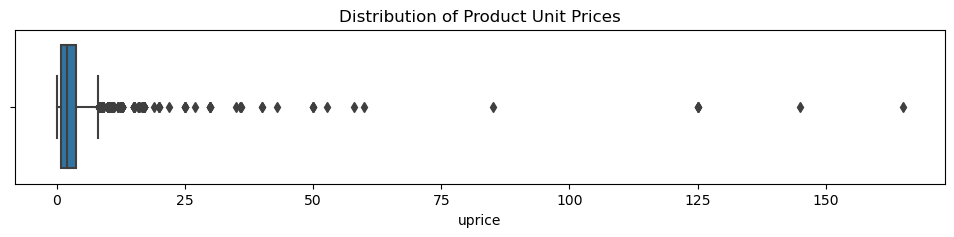

In [52]:
plt.figure(figsize = (12,2))
sns.boxplot(prodlist, x="uprice")
plt.title("Distribution of Product Unit Prices")

In [53]:
prodlist["uprice"].describe()

count    3646.000000
mean        3.369232
std         6.647226
min         0.040000
25%         0.850000
50%         1.950000
75%         3.750000
max       165.000000
Name: uprice, dtype: float64

In [54]:
prodlist["uprice"].quantile(q = 0.98)

14.95

We can see that most products (75%) have below 3.75 unit price. The 98% percentile price is around 14.95. Let's say we want to consider the premium products sold as products with uprice above 15. To have a better sense of the more premium products sold by the company, we want to examine the products that are above 15 dollars

In [55]:
prodlist[prodlist["uprice"] > 50].sort_values("uprice", ascending = False)

prodcode_num prodcode                            proddesc  uprice
99051          22828    22828        REGENCY MIRROR WITH SHUTTERS  165.00
4963           22827    22827  RUSTIC  SEVENTEEN DRAWER SIDEBOARD  145.00
4158           22823    22823       CHEST NATURAL WOOD 20 DRAWERS  125.00
7350           22655    22655         VINTAGE RED KITCHEN CABINET  125.00
62754          22656    22656        VINTAGE BLUE KITCHEN CABINET  125.00
469            22826    22826       LOVE SEAT ANTIQUE WHITE METAL   85.00
23113          84632    84632    DECORATIVE HANGING SHELVING UNIT   59.95
205967         22929    22929               SCHOOL DESK AND CHAIR   57.95
144813         21769    21769         VINTAGE POST OFFICE CABINET   52.77

### What are the top-selling products?

In [56]:
# extract out the orders that are purchases
purchase_items = cleaned[~cleaned["Orderno"].str.startswith("C")]

#### By prodcode (including different designs)

In [57]:
top_selling_items = purchase_items.groupby("prodcode", as_index=False)["qty"].sum().sort_values("qty", ascending=False).head(10)
top_selling_items_list = pd.merge(top_selling_items, prodlist, how = "left", on = "prodcode")
top_selling_items_list[["prodcode", "proddesc", "qty", "uprice"]]

prodcode                            proddesc    qty  uprice
0    23843         PAPER CRAFT , LITTLE BIRDIE  80995    2.08
1    84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS  47334    0.29
2    22197                      POPCORN HOLDER  36909    0.85
3   85099B             JUMBO BAG RED RETROSPOT  35861    2.08
4   85123A  WHITE HANGING HEART T-LIGHT HOLDER  31463    2.95
5    84879       ASSORTED COLOUR BIRD ORNAMENT  28924    1.69
6    21212     PACK OF 72 RETROSPOT CAKE CASES  27770    0.55
7    22492              MINI PAINT SET VINTAGE  22510    0.65
8    23084                  RABBIT NIGHT LIGHT  21829    1.79
9    22616           PACK OF 12 LONDON TISSUES  20701    0.39

#### By prodcode_num (regardless of design)

In [58]:
top_selling_items_type = purchase_items.groupby("prodcode_num", as_index=False)["qty"].sum().sort_values("qty", ascending=False).head(10)
top_selling_items_type_list = pd.merge(top_selling_items_type, prodlist, how = "left", on = "prodcode_num")
top_selling_items_type_list

prodcode_num    qty prodcode                            proddesc  uprice
0          23843  80995    23843         PAPER CRAFT , LITTLE BIRDIE    2.08
1          85099  59644   85099F                JUMBO BAG STRAWBERRY    2.08
2          85099  59644   85099B             JUMBO BAG RED RETROSPOT    2.08
3          85099  59644   85099C      JUMBO  BAG BAROQUE BLACK WHITE    2.08
4          84077  47334    84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS    0.29
5          22197  36909    22197                      POPCORN HOLDER    0.85
6          85123  31463   85123A  WHITE HANGING HEART T-LIGHT HOLDER    2.95
7          84879  28924    84879       ASSORTED COLOUR BIRD ORNAMENT    1.69
8          21212  27770    21212     PACK OF 72 RETROSPOT CAKE CASES    0.55
9          22492  22510    22492              MINI PAINT SET VINTAGE    0.65
10         23084  21829    23084                  RABBIT NIGHT LIGHT    1.79
11         22616  20701    22616           PACK OF 12 LONDON TISSUES    0.39

### Which products have the highest returns?

In [59]:
return_items = cleaned[cleaned["Orderno"].str.startswith("C")]

In [60]:
highest_return_items = return_items.groupby("prodcode", as_index = False)["qty"].sum().sort_values("qty", ascending = True).head(10)
highest_return_items_list = pd.merge(highest_return_items, prodlist, how = "left", on = "prodcode")
highest_return_items_list[["prodcode", "proddesc", "qty", "uprice"]]

prodcode                             proddesc    qty  uprice
0    23166       MEDIUM CERAMIC TOP STORAGE JAR -74479    1.25
1    84347  ROTATING SILVER ANGELS T-LIGHT HLDR  -9367    2.55
2    21108   FAIRY CAKE FLANNEL ASSORTED COLOUR  -3150    0.79
3   85123A   WHITE HANGING HEART T-LIGHT HOLDER  -2534    2.95
4    21175          GIN + TONIC DIET METAL SIGN  -2030    2.55
5    22920                    HERB MARKER BASIL  -1527    0.65
6   47566B               TEA TIME PARTY BUNTING  -1391    4.65
7    15034           PAPER POCKET TRAVELING FAN  -1385    0.14
8    20971     PINK BLUE FELT CRAFT TRINKET BOX  -1321    1.25
9    84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS  -1152    0.29

## Exploration on order level
- What are the total number of orders received? What is the proportion of returns compared to orders?
- What is the average order value?
- Distribution of orders by year_month, month, dayofweek?

### What is the total number of orders and returns? What is the proportion of returns compared to orders?

In [61]:
# separate purchase and return orders
purchase_orders = orders_combined[~orders_combined["orderno"].str.startswith("C")]
return_orders = orders_combined[orders_combined["orderno"].str.startswith("C")]

# print the num of orders and returns
print(f"Num of purchase orders: {len(purchase_orders)}")
print(f"Num of return orders: {len(return_orders)}")
print(f"Proportion of return orders vs purchase orders: {round(len(return_orders) / len(purchase_orders) * 100, 2)}%")

Num of purchase orders: 18088
Num of return orders: 3000
Proportion of return orders vs purchase orders: 16.59%


### What is the average order value?

Text(0.5, 1.0, 'Distribution of Order Value')

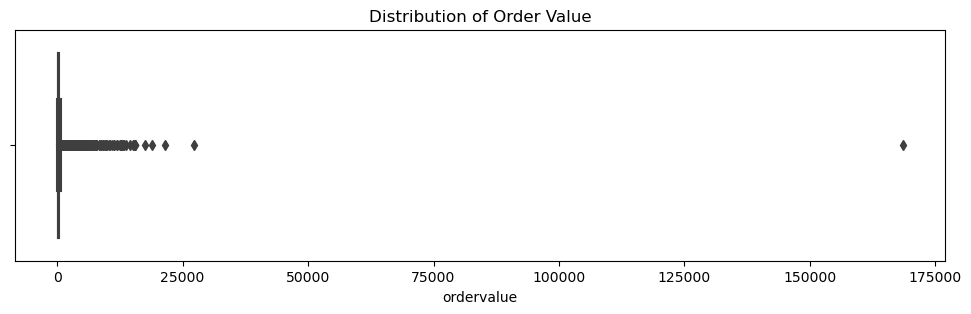

In [62]:
plt.figure(figsize = (12,3))
sns.boxplot(purchase_orders, x="ordervalue")
plt.title("Distribution of Order Value")

In [63]:
purchase_orders["ordervalue"].describe()

count     18088.000000
mean        383.410712
std        1472.653758
min           0.000000
25%         126.070000
50%         235.800000
75%         376.920000
max      168469.600000
Name: ordervalue, dtype: float64

In [64]:
purchase_orders[purchase_orders["ordervalue"] == purchase_orders["ordervalue"].max()]

orderno                date  custid         country  numuniqueprod   
20887  581483 2011-12-09 09:15:00   16446  United Kingdom              1  \

       totalqty  ordervalue  daysinceorder  ordermonth orderdayofweek   
20887     80995    168469.6             21          12         Friday  \

      ordermonthyear  
20887        2011-12

In [65]:
purchase_orders.sort_values("ordervalue", ascending=False).head(10)

orderno                date  custid         country  numuniqueprod   
20887  581483 2011-12-09 09:15:00   16446  United Kingdom              1  \
7042   567423 2011-09-20 11:05:00   17450  United Kingdom             10   
17270  550461 2011-04-18 13:20:00   15749  United Kingdom              5   
15715  572209 2011-10-21 12:08:00   18102  United Kingdom              6   
3959   556917 2011-06-15 13:37:00   12415       Australia            111   
3394   563614 2011-08-18 08:51:00   12415       Australia             76   
6588   567381 2011-09-20 10:12:00   17450  United Kingdom              9   
5065   572035 2011-10-20 12:03:00   14646     Netherlands             97   
8762   562439 2011-08-04 18:06:00   12931  United Kingdom             18   
18954  540815 2011-01-11 12:55:00   15749  United Kingdom              3   

       totalqty  ordervalue  daysinceorder  ordermonth orderdayofweek   
20887     80995   168469.60             21          12         Friday  \
7042      11472    27283.56            101           9        Tuesday   
17270      9014    21535.90            256           4         Monday   
15715      1620    18921.00             70          10         Friday   
3959      11323    17546.57            198           6      Wednesday   
3394       9644    15557.40            134           8       Thursday   
6588       5432    15540.00            101           9        Tuesday   
5065      10044    15535.72             71          10       Thursday   
8762       9000    15332.56            148           8       Thursday   
18954      7044    15160.90            353           1        Tuesday   

      ordermonthyear  
20887        2011-12  
7042         2011-09  
17270        2011-04  
15715        2011-10  
3959         2011-06  
3394         2011-08  
6588         2011-09  
5065         2011-10  
8762         2011-08  
18954        2011-01

We can see that there are some orders with very high order value and the main reasons can be attributed to a very high quantity of products ordered. These are customers that are likely more prone to bulk buying, potentially corporate customers.

### Distribution of orders by year

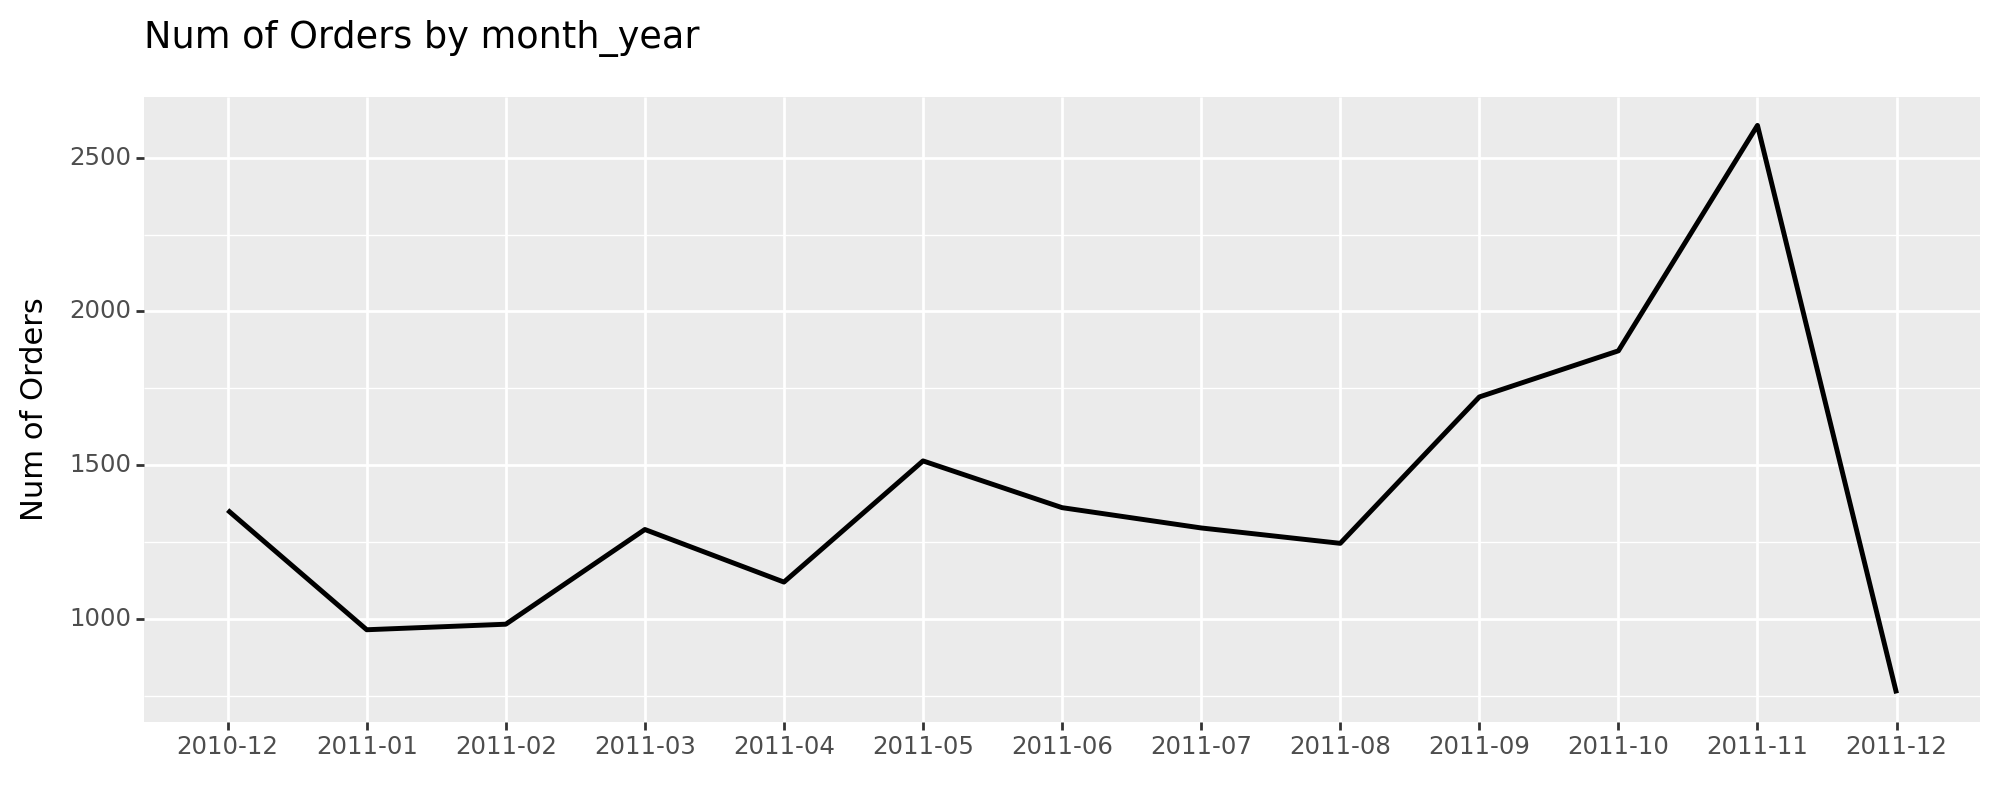

<Figure Size: (1000 x 400)>

In [66]:
num_of_orders_bymonthyear = purchase_orders.groupby(by = "ordermonthyear", as_index = False)["orderno"].count()

plotnine.options.figure_size = (10,4)
(ggplot(num_of_orders_bymonthyear, aes(x = "ordermonthyear", y = "orderno"))
 + geom_line(group = "ordermonthyear", size = 1)
 + labs(y = "Num of Orders",
        title = "Num of Orders by month_year")
 + theme(axis_title_x = element_blank())
)

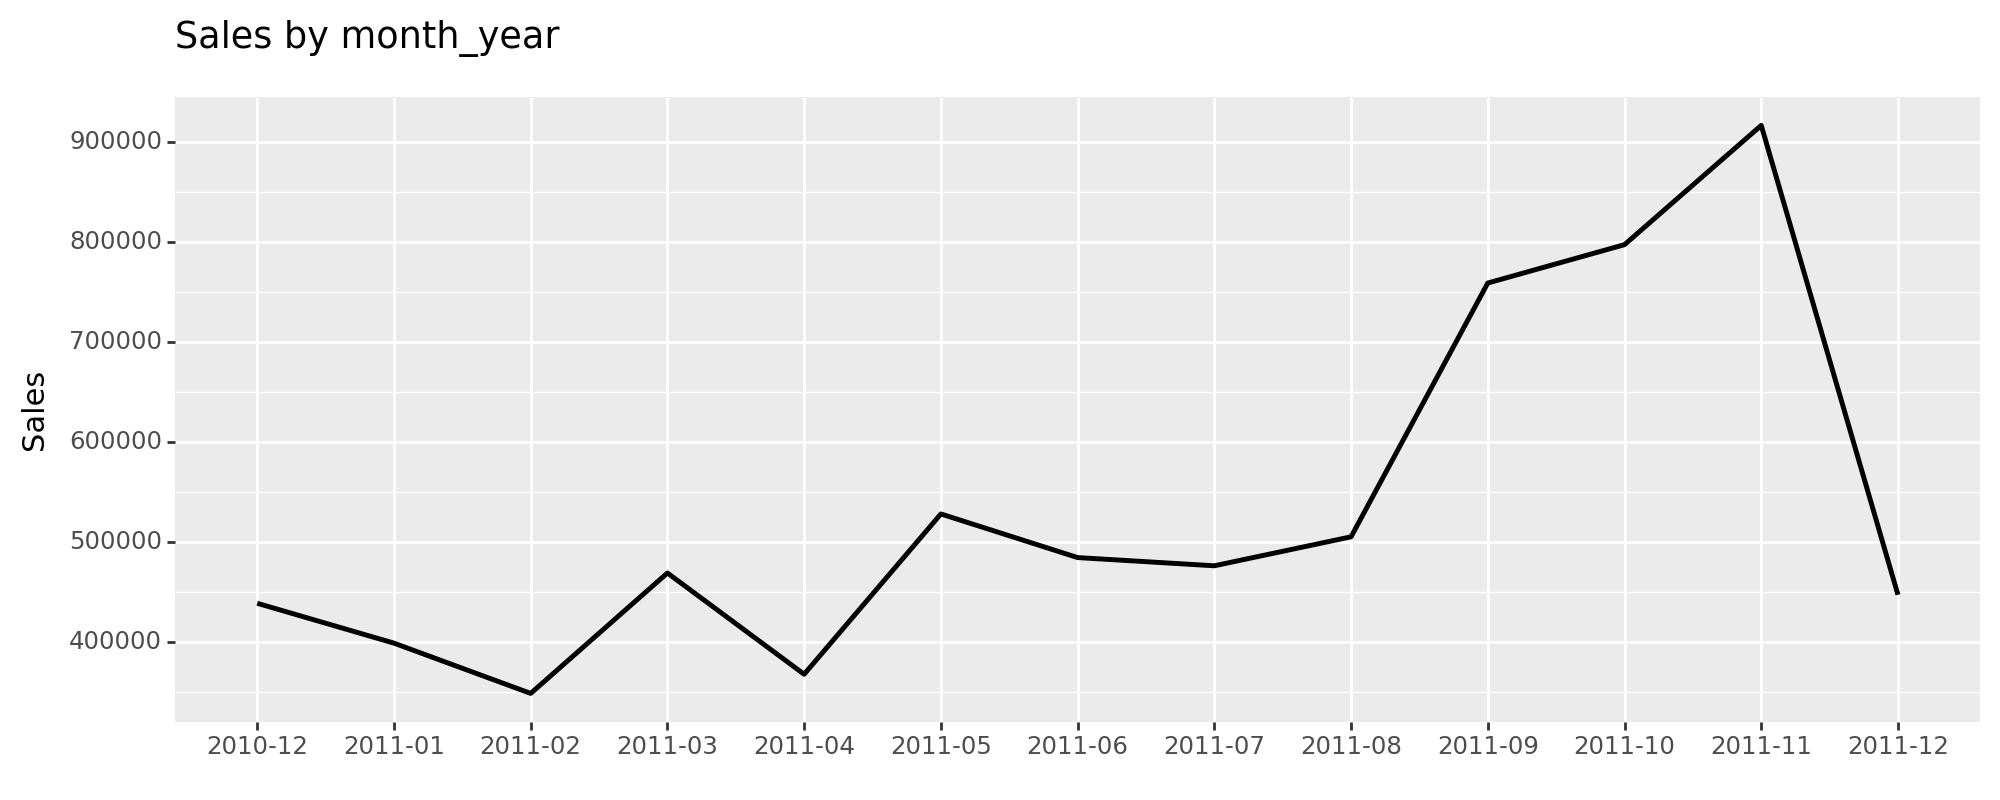

<Figure Size: (1000 x 400)>

In [67]:
sales_bymonthyear = purchase_orders.groupby(by = "ordermonthyear", as_index = False)["ordervalue"].sum()

figsize = (10,8)
(ggplot(sales_bymonthyear, aes(x = "ordermonthyear", y = "ordervalue"))
 + geom_line(group = "ordermonthyear", size = 1)
 + labs(y = "Sales",
        title = "Sales by month_year")
 + theme(axis_title_x = element_blank())
)

### Distribution of orders by month

Text(0.5, 1.0, 'Num of Orders per Month and Day of Week')

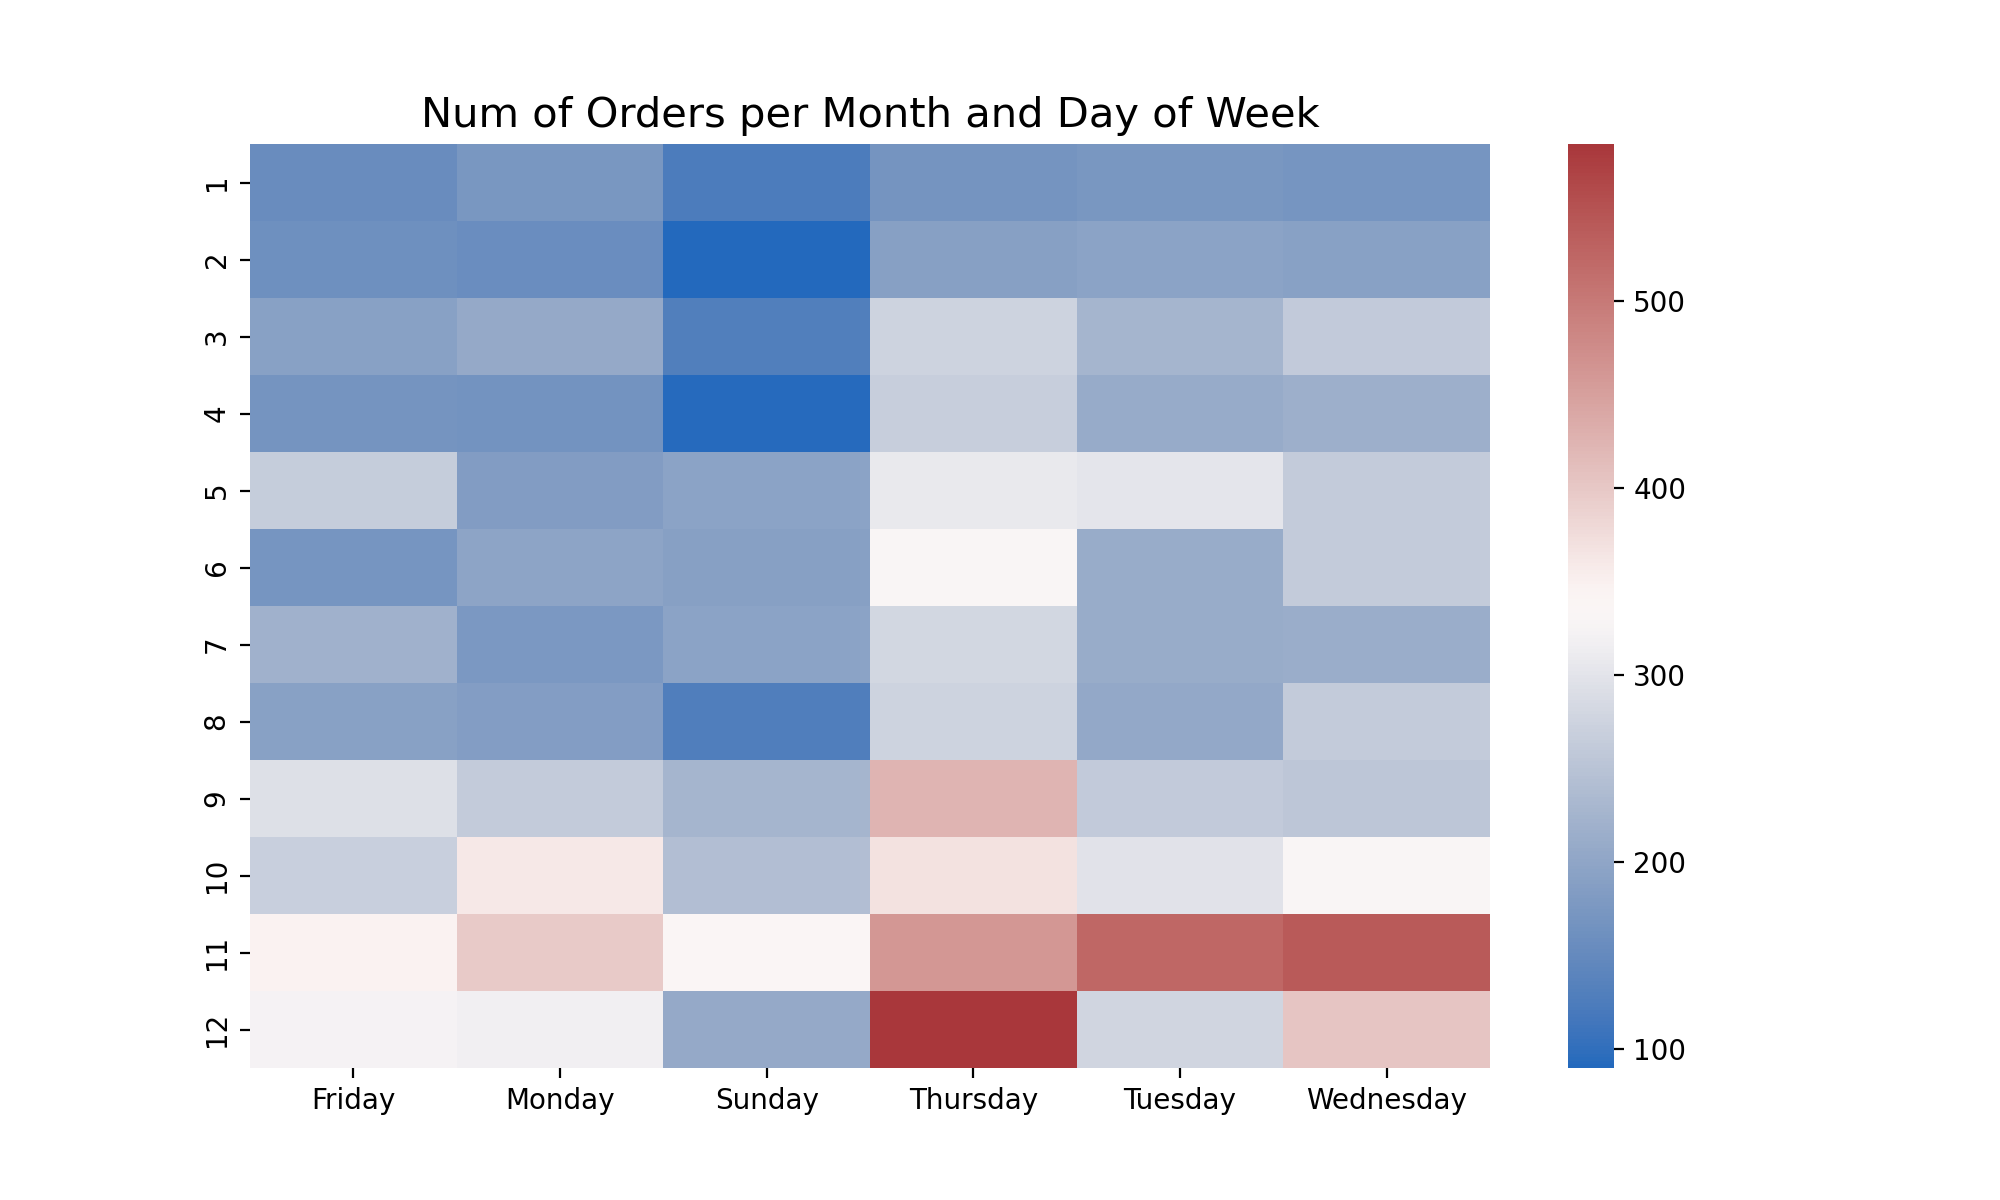

In [68]:
orders_heatmap = purchase_orders.pivot_table(index = "ordermonth", columns = "orderdayofweek", values = "orderno", aggfunc = "count")
plt.figure(figsize = (10,6))
sns.heatmap(orders_heatmap, cmap = 'vlag').set(xlabel='', ylabel='')
plt.title('Num of Orders per Month and Day of Week', fontsize = 15)

Text(0.5, 1.0, 'Sales per Month and Day of Week')

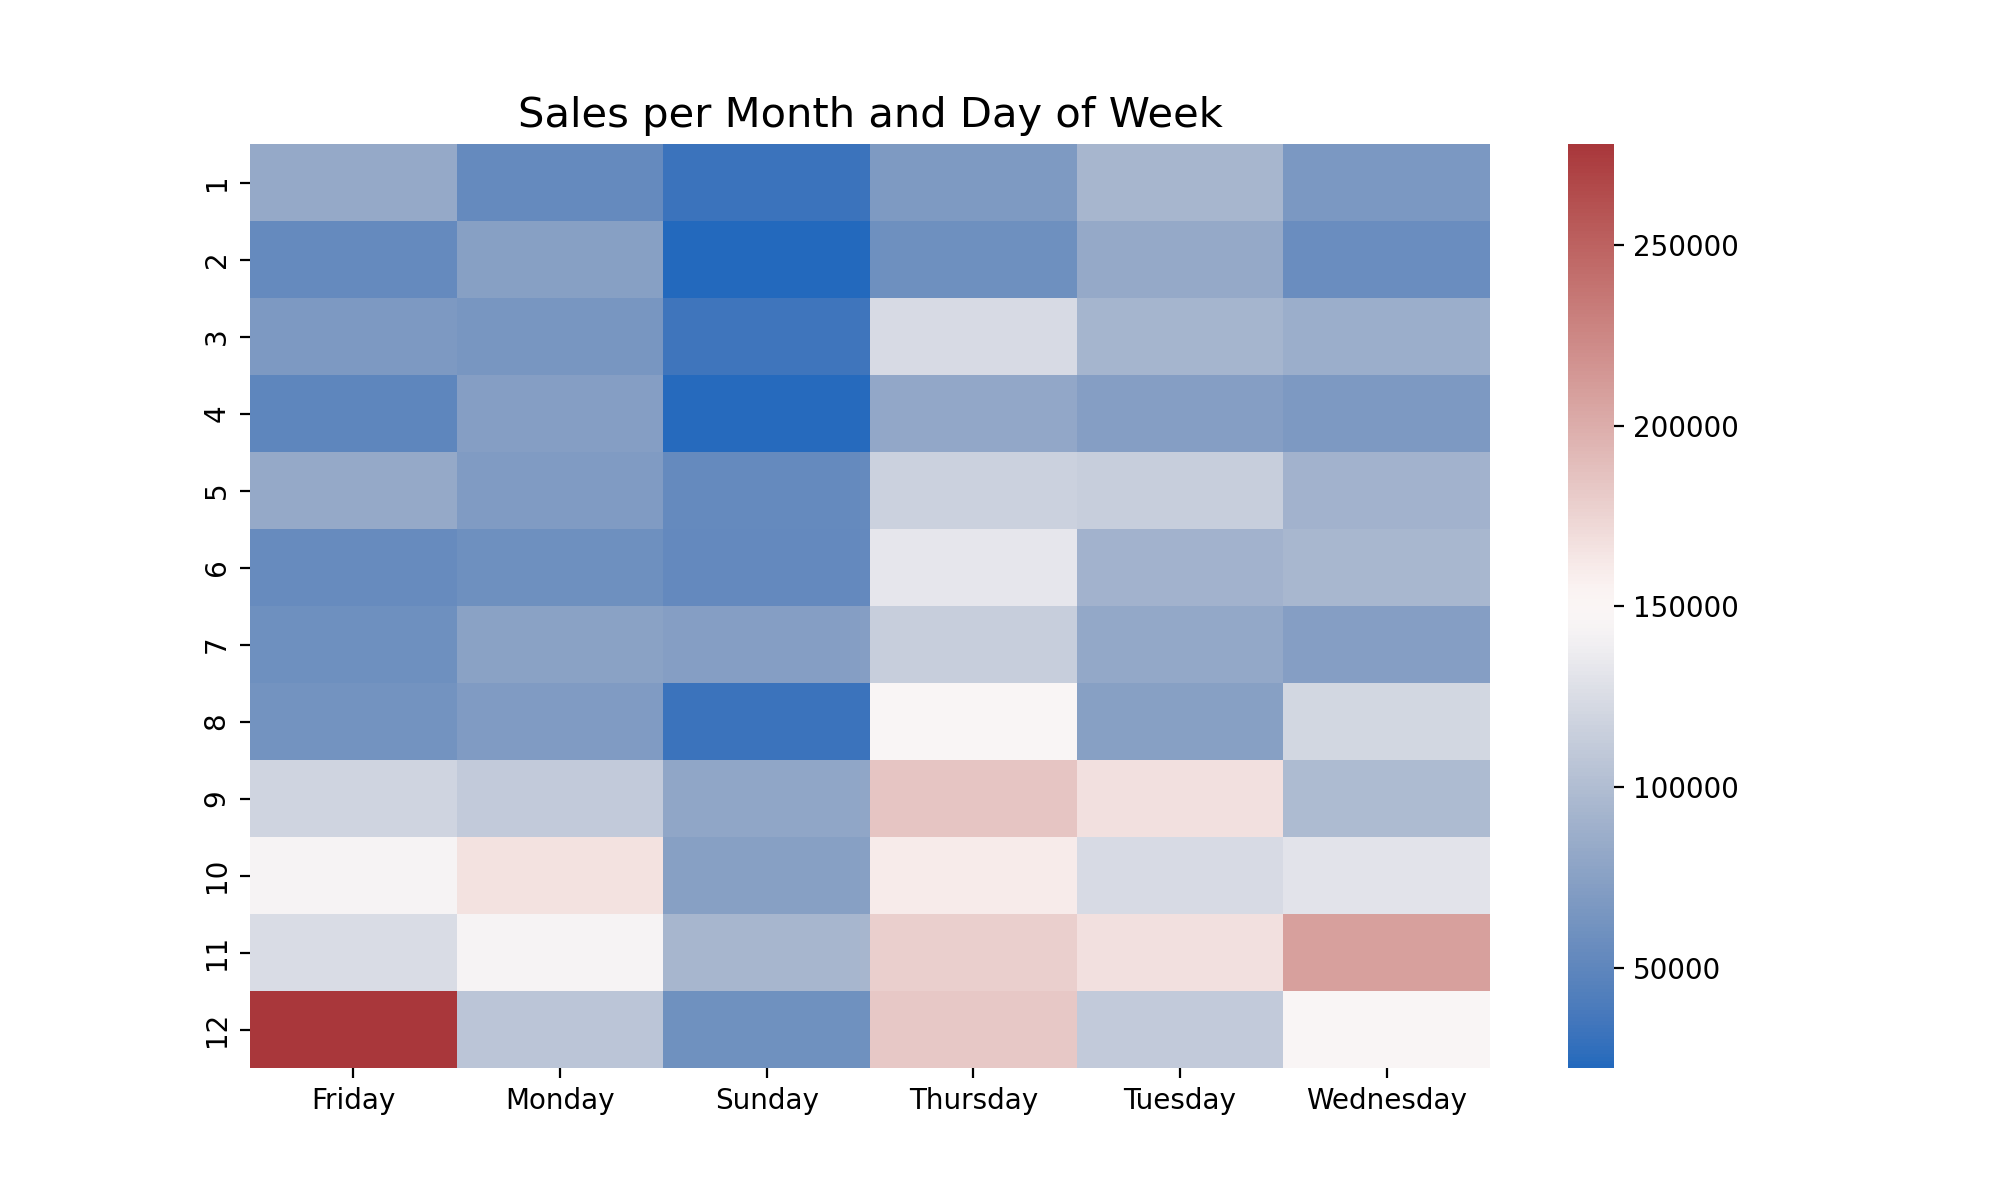

In [69]:
sales_heatmap = purchase_orders.pivot_table(index = "ordermonth", columns = "orderdayofweek", values = "ordervalue", aggfunc = "sum")
plt.figure(figsize = (10,6))
sns.heatmap(sales_heatmap, cmap = 'vlag').set(xlabel='', ylabel='')
plt.title('Sales per Month and Day of Week', fontsize = 15)

## Exploration on customer level
- What is geographical distribution of customers?
- What is the average number of orders per customer? Any outliers?
- Who are the top customers?
- Customer segmentation and market basket analysis

### What is the geographical distribution of customers?

In [70]:
cust_geography = customers_combined.groupby("country", as_index = False)["custid"].count()
cust_geography = cust_geography.sort_values("custid", ascending=False).head(10)
cust_geography

country  custid
35  United Kingdom    3903
14         Germany      93
13          France      87
30           Spain      28
3          Belgium      23
32     Switzerland      21
26        Portugal      19
18           Italy      14
12         Finland      12
1          Austria      10

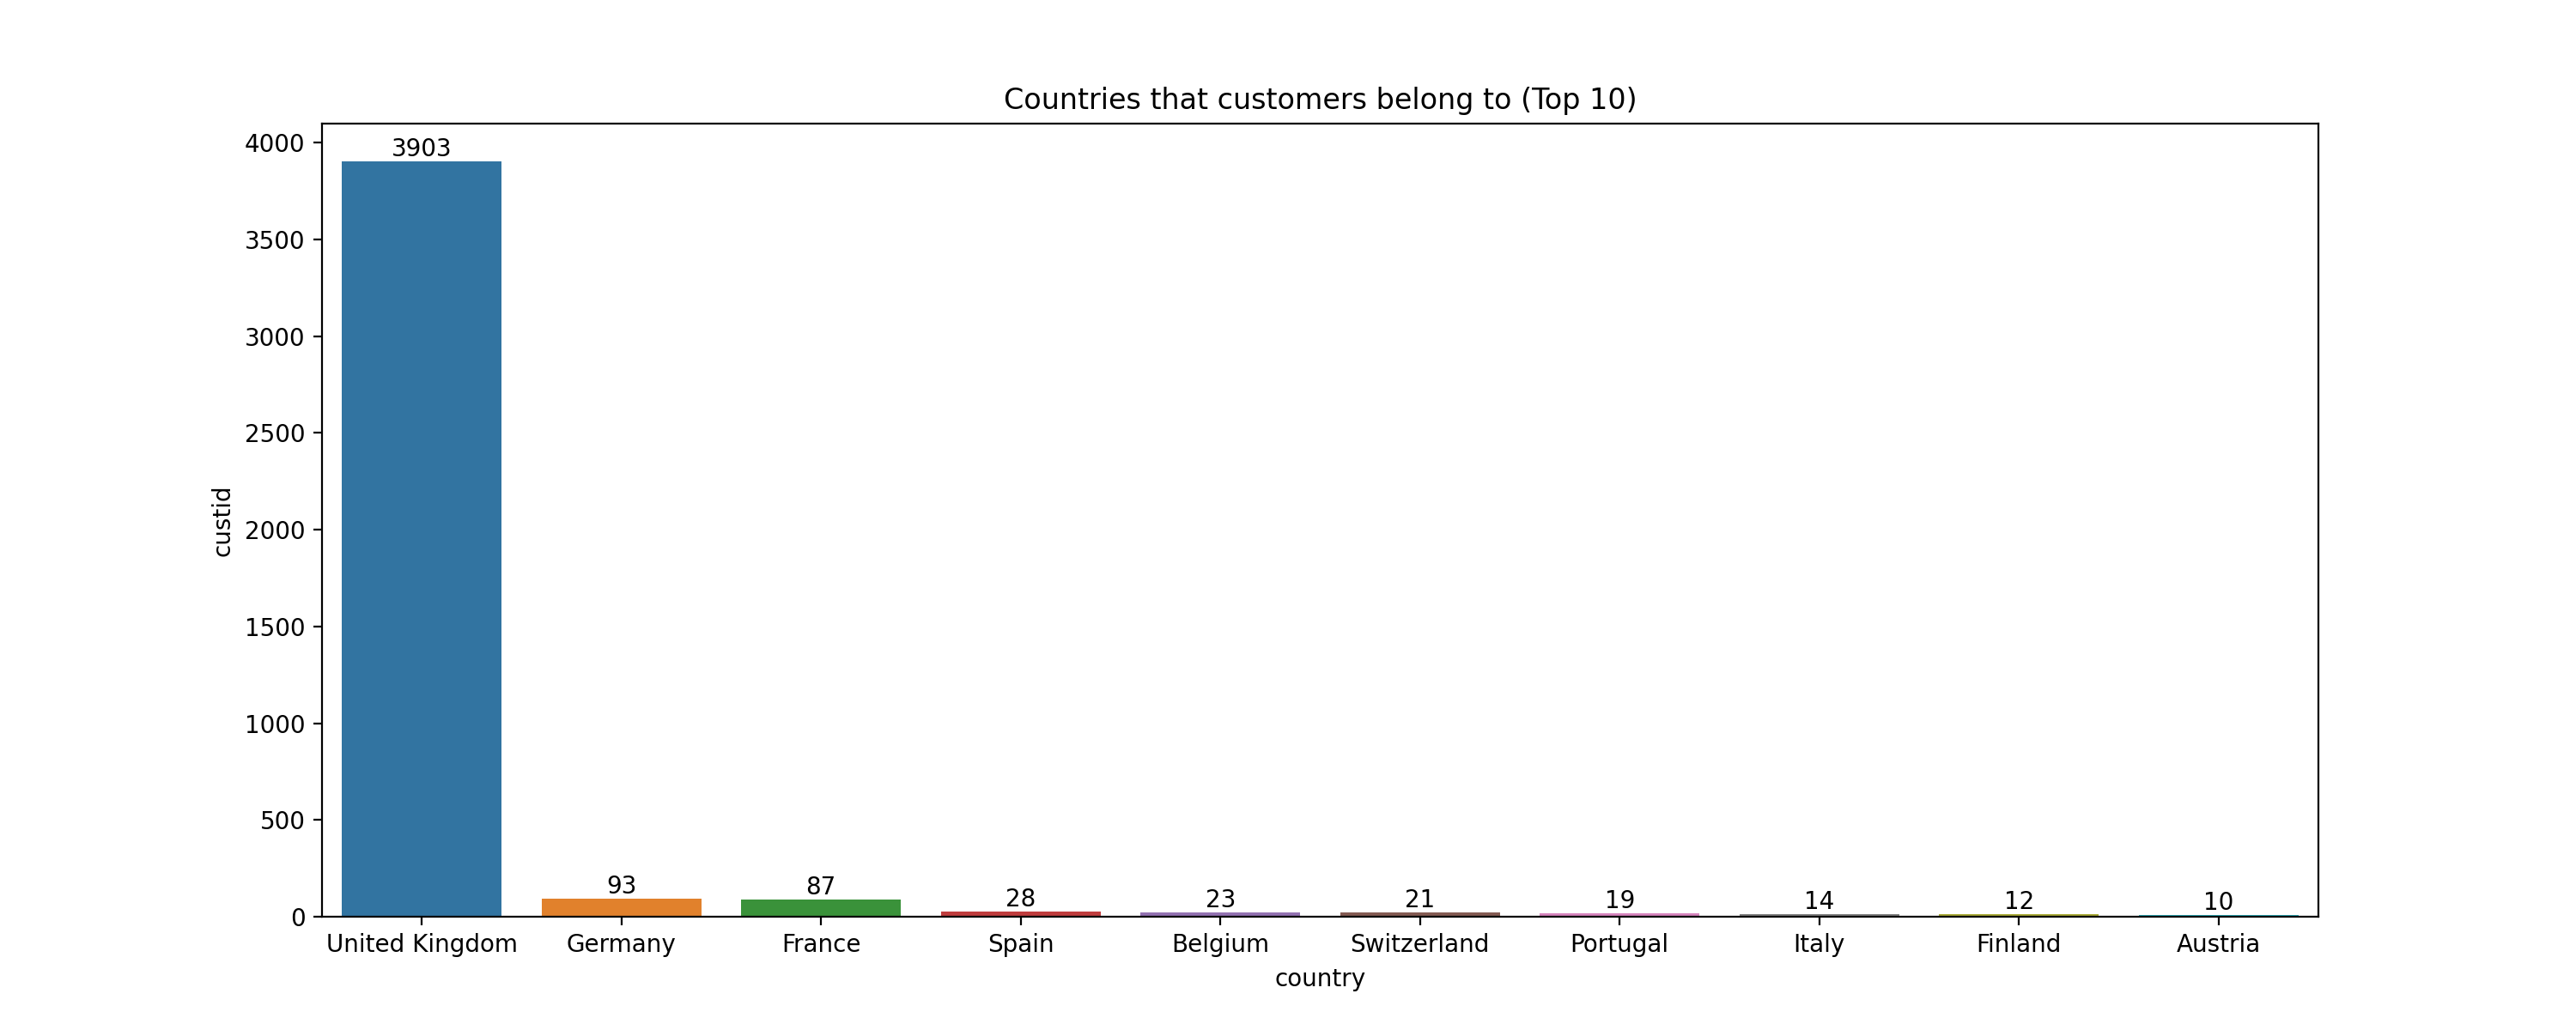

In [71]:
plt.figure(figsize = (15,6))
ax = sns.barplot(data = cust_geography, x = "country", y = "custid")
ax.bar_label(ax.containers[0]);
plt.title("Countries that customers belong to (Top 10)");

In [72]:
# add column to indicate whether customers from UK or Others
customers_combined["UK_Others"] = customers_combined["country"].apply(lambda x: "UK" if x == "United Kingdom" else "Others")

### Which customers have the highest total order value?

In [73]:
test = customers_combined.sort_values("total_ordervalue", ascending = False)[["custid", "country", "total_ordervalue"]]
test.columns = ["custid", "country", "monetary"]
test

custid         country   monetary
8      14646     Netherlands  231261.94
480    18102  United Kingdom  209798.38
4302   16446  United Kingdom  168471.25
770    17450  United Kingdom  166093.35
55     14911            EIRE  109673.50
...      ...             ...        ...
4335   18019  United Kingdom       9.90
4324   15423  United Kingdom       7.50
3006   16454  United Kingdom       5.90
3666   14792  United Kingdom       1.95
4235   13256  United Kingdom       0.00

[4318 rows x 3 columns]

### What is the average number of orders per customer? Any outliers?

Text(0.5, 1.0, 'Distribution of Orders per Customer')

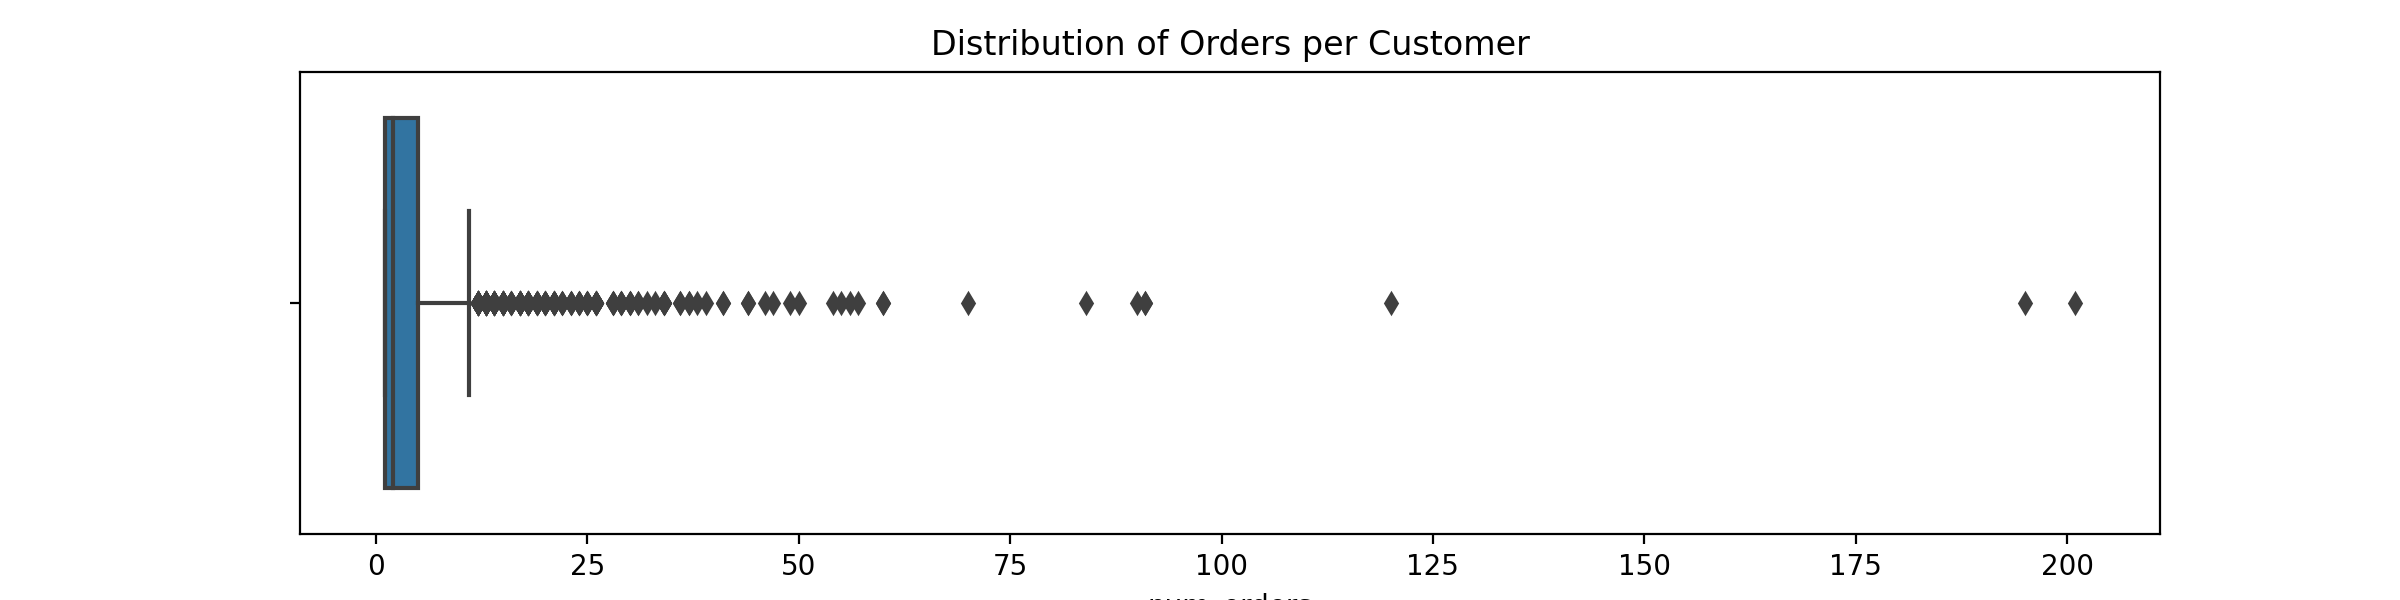

In [74]:
plt.figure(figsize = (12,3))
sns.boxplot(customers_combined, x="num_orders")
plt.title("Distribution of Orders per Customer")

In [75]:
customers_combined["num_orders"].describe()

count    4318.000000
mean        4.188976
std         7.463816
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       201.000000
Name: num_orders, dtype: float64

We can see that the average number of orders is 4 but the max is 201. There are some outliers.

# Customer Segementation

## RFM Analysis

In [76]:
rfm = customers_combined[["custid", "daysincelastorder", "num_orders", "total_ordervalue"]]
rfm.head()

custid  daysincelastorder  num_orders  total_ordervalue
0   17841               22.0       120.0          32659.87
1   18069               47.0         5.0           1675.93
2   12714               30.0         5.0           3745.27
3   14470               32.0         2.0            395.35
4   18158               30.0         2.0            419.40

In [77]:
# reverse daysincelastorder to reflect higher value with more recent
rfm["recency"] = rfm["daysincelastorder"] * -1

# drop column
rfm = rfm.drop("daysincelastorder", axis = 1)

# rename columns
rfm.columns = ["custid", "frequency", "monetary", "recency"]

C:\Users\fongb\AppData\Local\Temp\ipykernel_18784\402965395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [78]:
# create quartile values using qcut function
r_quartiles_wo_labels = pd.qcut(rfm["recency"], 4)
m_quartiles_wo_labels = pd.qcut(rfm['monetary'], 4)
f_quartiles_wo_labels = pd.qcut(rfm['frequency'], 4, duplicates="drop")

# quartiles with labels
# create Lables for each rfm metric
r_labels = range(1,5)
m_labels = range(1,5)
f_labels = range(1,4)

# create quartile Values using qcut function
r_quartiles = pd.qcut(rfm["recency"], 4, labels = r_labels)
m_quartiles = pd.qcut(rfm['monetary'], 4, labels = m_labels)
f_quartiles = pd.qcut(rfm['frequency'], 4, labels = f_labels, duplicates="drop")

# assign R,F,M quartile values to customers
rfm_segments = rfm.assign(R_range = r_quartiles_wo_labels, F_range = f_quartiles_wo_labels, M_range = m_quartiles_wo_labels)
rfm_segments = rfm_segments.assign(R = r_quartiles, F = f_quartiles, M = m_quartiles)

# look at new dataset
rfm_segments.head()

custid  frequency  monetary  recency         R_range       F_range   
0   17841      120.0  32659.87    -22.0  (-38.0, -21.0]  (5.0, 201.0]  \
1   18069        5.0   1675.93    -47.0  (-71.0, -38.0]    (2.0, 5.0]   
2   12714        5.0   3745.27    -30.0  (-38.0, -21.0]    (2.0, 5.0]   
3   14470        2.0    395.35    -32.0  (-38.0, -21.0]  (0.999, 2.0]   
4   18158        2.0    419.40    -30.0  (-38.0, -21.0]  (0.999, 2.0]   

                M_range  R  F  M  
0  (1295.68, 231261.94]  4  3  4  
1  (1295.68, 231261.94]  3  2  4  
2  (1295.68, 231261.94]  4  2  4  
3    (236.845, 531.725]  4  1  2  
4    (236.845, 531.725]  4  1  2

In [79]:
# derive RFM segment
def join_rfm(x):
    return str(int(x["R"])) + str(int(x["F"])) + str(int(x["M"]))

rfm_segments["rfm_segment"] = rfm_segments.apply(join_rfm, axis=1)

# derive RFM score
rfm_segments["rfm_score"] = rfm_segments[["R", "F", "M"]].sum(axis = 1)

# look at data
rfm_segments.head()

custid  frequency  monetary  recency         R_range       F_range   
0   17841      120.0  32659.87    -22.0  (-38.0, -21.0]  (5.0, 201.0]  \
1   18069        5.0   1675.93    -47.0  (-71.0, -38.0]    (2.0, 5.0]   
2   12714        5.0   3745.27    -30.0  (-38.0, -21.0]    (2.0, 5.0]   
3   14470        2.0    395.35    -32.0  (-38.0, -21.0]  (0.999, 2.0]   
4   18158        2.0    419.40    -30.0  (-38.0, -21.0]  (0.999, 2.0]   

                M_range  R  F  M rfm_segment  rfm_score  
0  (1295.68, 231261.94]  4  3  4         434         11  
1  (1295.68, 231261.94]  3  2  4         324          9  
2  (1295.68, 231261.94]  4  2  4         424         10  
3    (236.845, 531.725]  4  1  2         412          7  
4    (236.845, 531.725]  4  1  2         412          7

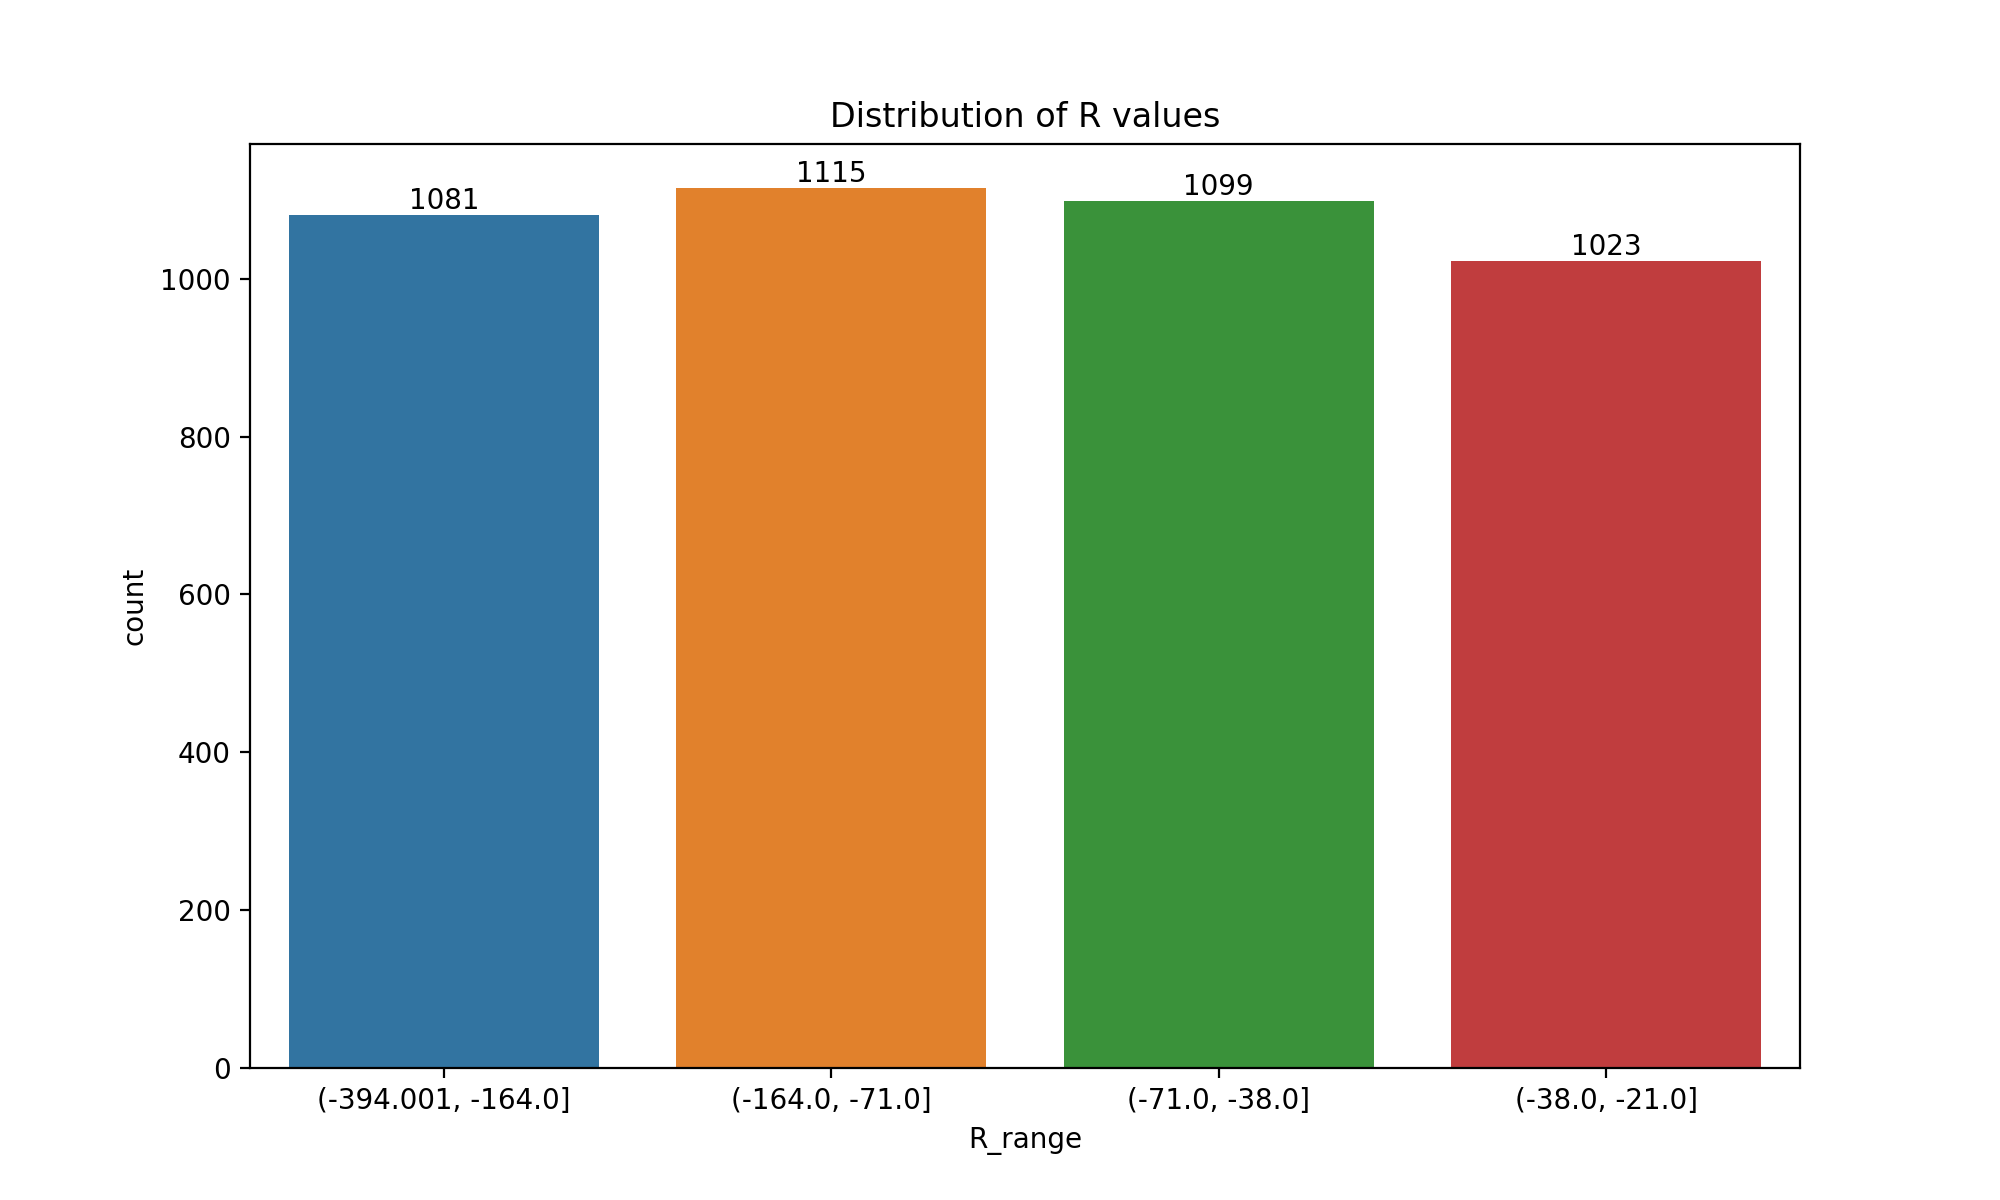

In [80]:
plt.figure(figsize = (10,6))
ax = sns.countplot(data = rfm_segments, x = "R_range")
ax.bar_label(ax.containers[0]);
plt.title("Distribution of R values");

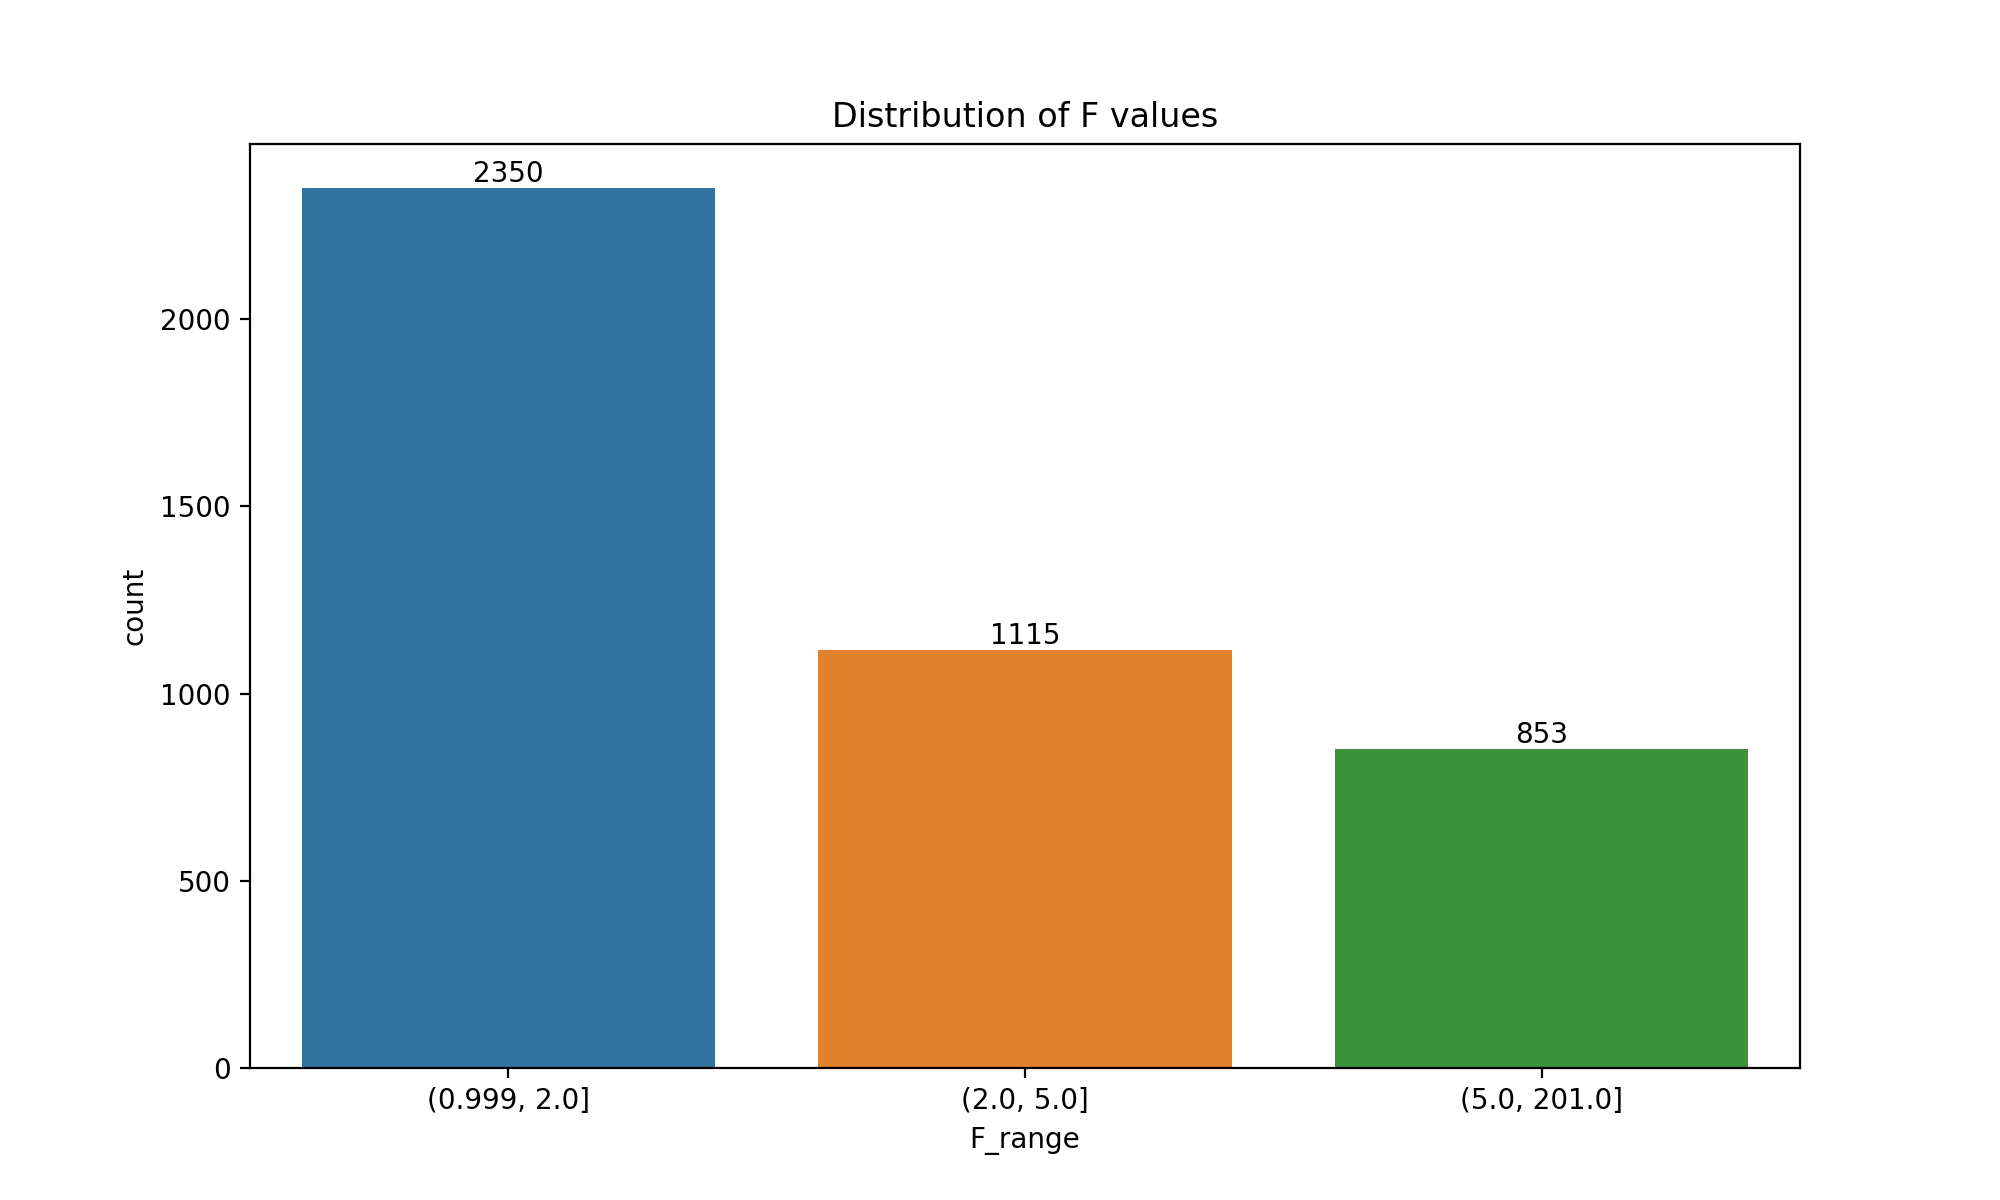

In [81]:
plt.figure(figsize = (10,6))
ax = sns.countplot(data = rfm_segments, x = "F_range")
ax.bar_label(ax.containers[0]);
plt.title("Distribution of F values");

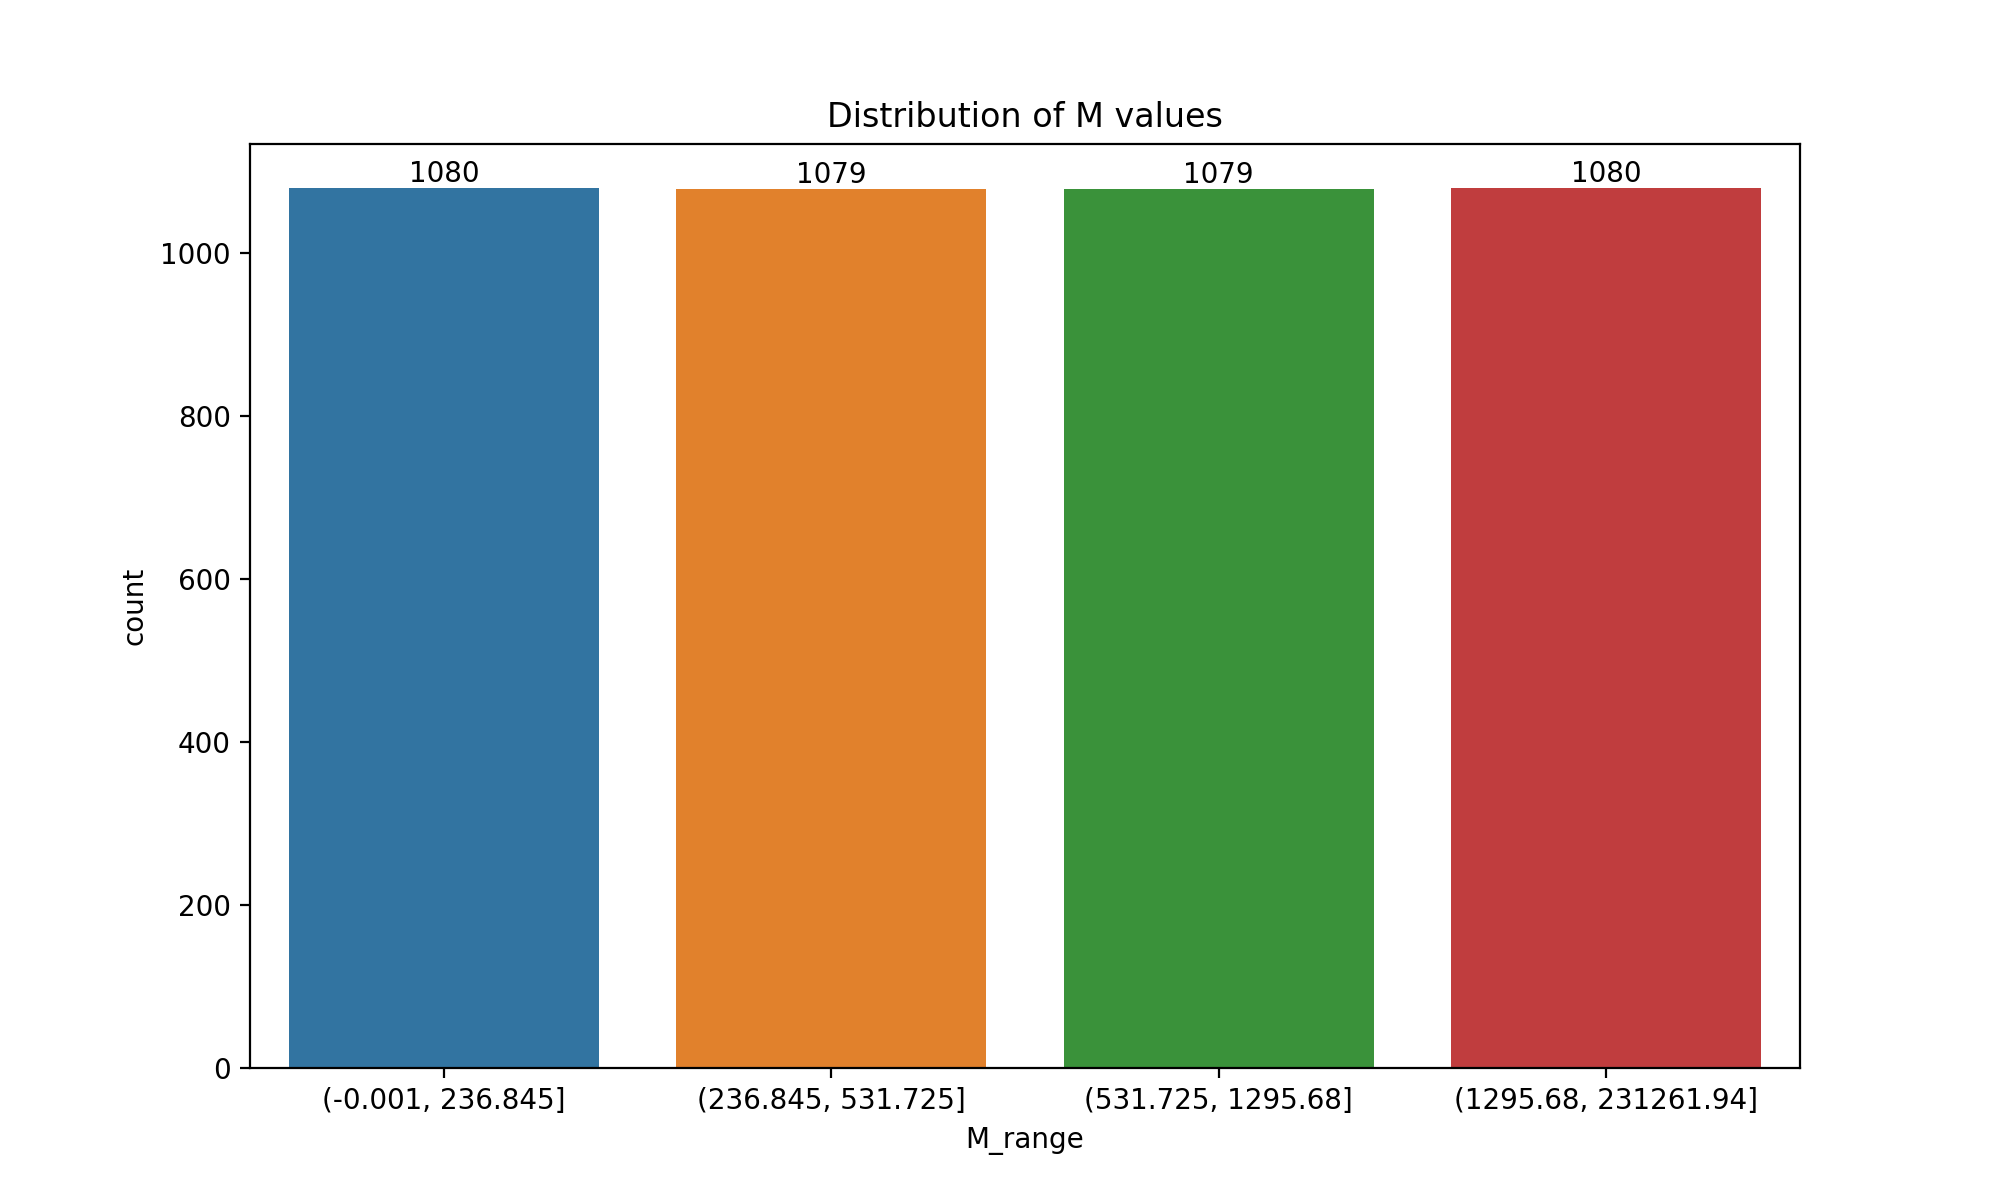

In [82]:
plt.figure(figsize = (10,6))
ax = sns.countplot(data = rfm_segments, x = "M_range")
ax.bar_label(ax.containers[0]);
plt.title("Distribution of M values");

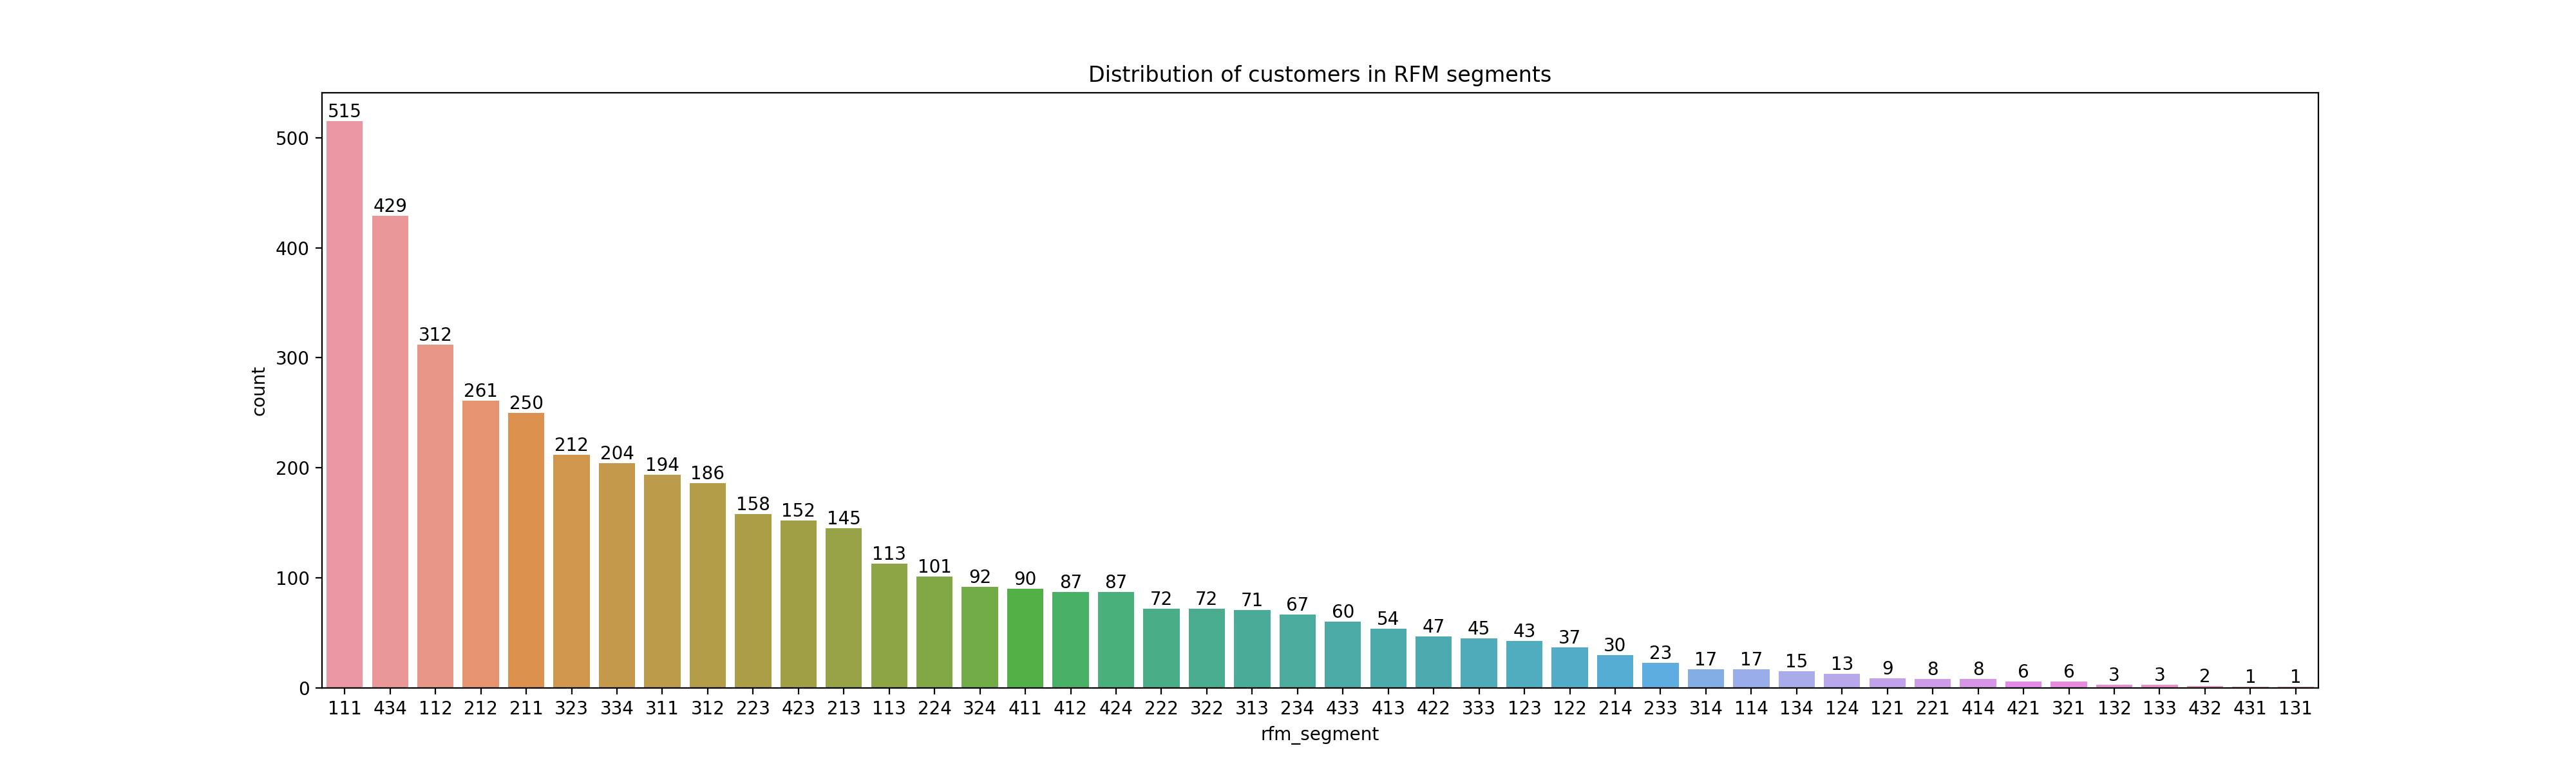

In [83]:
# plot distribution of RFM_segments
plt.figure(figsize = (20,6))
ax = sns.countplot(data = rfm_segments, x = "rfm_segment", order = rfm_segments['rfm_segment'].value_counts().index)
ax.set(title = "Distribution of customers in RFM segments")
ax.bar_label(ax.containers[0]);

In [84]:
# group by rfm score and check mean values of recency, frequency and monetary
rfm_segments.groupby("rfm_score")[["recency", "frequency", "monetary"]].mean()

recency  frequency     monetary
rfm_score                                    
3         -281.027184   1.122330   134.992893
4         -197.572680   1.280210   250.792750
5         -122.407166   1.532573   370.072899
6          -88.523132   1.971530   530.461139
7          -75.690909   2.747727   894.418136
8          -64.176596   3.870213  1180.232915
9          -48.677596   5.153005  2049.605027
10         -40.353276   8.176638  3328.843704
11         -27.226107  16.191142  7762.778555

## K Means Clustering

In [85]:
customers_full = pd.merge(customers_combined, rfm_segments, on = "custid", how = "left")
customers_full.head()

custid         country  num_orders  mean_prod_in_order  total_prod_ordered   
0   17841  United Kingdom       120.0                49.9                5988  \
1   18069  United Kingdom         5.0                72.8                 364   
2   12714          France         5.0                43.6                 218   
3   14470  United Kingdom         2.0                17.5                  35   
4   18158  United Kingdom         2.0                15.0                  30   

   mean_ordervalue  total_ordervalue  daysincelastorder  meanqtyofprodinorder   
0       272.165583          32659.87               22.0            150.791667  \
1       335.186000           1675.93               47.0            208.600000   
2       749.054000           3745.27               30.0            522.200000   
3       197.675000            395.35               32.0             82.500000   
4       209.700000            419.40               30.0            157.000000   

   totalqtyofprodinorder  num_returns  mean_prod_in_return   
0                18095.0         43.0             2.465116  \
1                 1043.0          2.0                  1.0   
2                 2611.0          0.0                  0.0   
3                  165.0          0.0                  0.0   
4                  314.0          0.0                  0.0   

   total_prod_returned  mean_returnvalue  total_returnvalue   
0                  106        -12.035814            -517.54  \
1                    2         -7.425000             -14.85   
2                    0          0.000000               0.00   
3                    0          0.000000               0.00   
4                    0          0.000000               0.00   

   daysincelastreturn  tenure  avg_days_between_purchases  avg_prod_value   
0                37.0   371.0                    3.091667         5.45422  \
1                47.0   301.0                   60.200000        4.604203   
2                 0.0   285.0                   57.000000       17.180138   
3                 0.0   275.0                  137.500000       11.295714   
4                 0.0    79.0                   39.500000           13.98   

  UK_Others  frequency  monetary  recency         R_range       F_range   
0        UK      120.0  32659.87    -22.0  (-38.0, -21.0]  (5.0, 201.0]  \
1        UK        5.0   1675.93    -47.0  (-71.0, -38.0]    (2.0, 5.0]   
2    Others        5.0   3745.27    -30.0  (-38.0, -21.0]    (2.0, 5.0]   
3        UK        2.0    395.35    -32.0  (-38.0, -21.0]  (0.999, 2.0]   
4        UK        2.0    419.40    -30.0  (-38.0, -21.0]  (0.999, 2.0]   

                M_range  R  F  M rfm_segment  rfm_score  
0  (1295.68, 231261.94]  4  3  4         434         11  
1  (1295.68, 231261.94]  3  2  4         324          9  
2  (1295.68, 231261.94]  4  2  4         424         10  
3    (236.845, 531.725]  4  1  2         412          7  
4    (236.845, 531.725]  4  1  2         412          7

In [86]:
# extract some of the relevant variables for k means clustering
customers_selected = customers_full[["custid", "frequency", "monetary", "daysincelastorder", "mean_prod_in_order",
                                    "mean_ordervalue", "meanqtyofprodinorder", "num_returns", "avg_days_between_purchases", "avg_prod_value", "UK_Others"]]

customers_selected.head()

custid  frequency  monetary  daysincelastorder  mean_prod_in_order   
0   17841      120.0  32659.87               22.0                49.9  \
1   18069        5.0   1675.93               47.0                72.8   
2   12714        5.0   3745.27               30.0                43.6   
3   14470        2.0    395.35               32.0                17.5   
4   18158        2.0    419.40               30.0                15.0   

   mean_ordervalue  meanqtyofprodinorder  num_returns   
0       272.165583            150.791667         43.0  \
1       335.186000            208.600000          2.0   
2       749.054000            522.200000          0.0   
3       197.675000             82.500000          0.0   
4       209.700000            157.000000          0.0   

   avg_days_between_purchases  avg_prod_value UK_Others  
0                    3.091667         5.45422        UK  
1                   60.200000        4.604203        UK  
2                   57.000000       17.180138    Others  
3                  137.500000       11.295714        UK  
4                   39.500000           13.98        UK

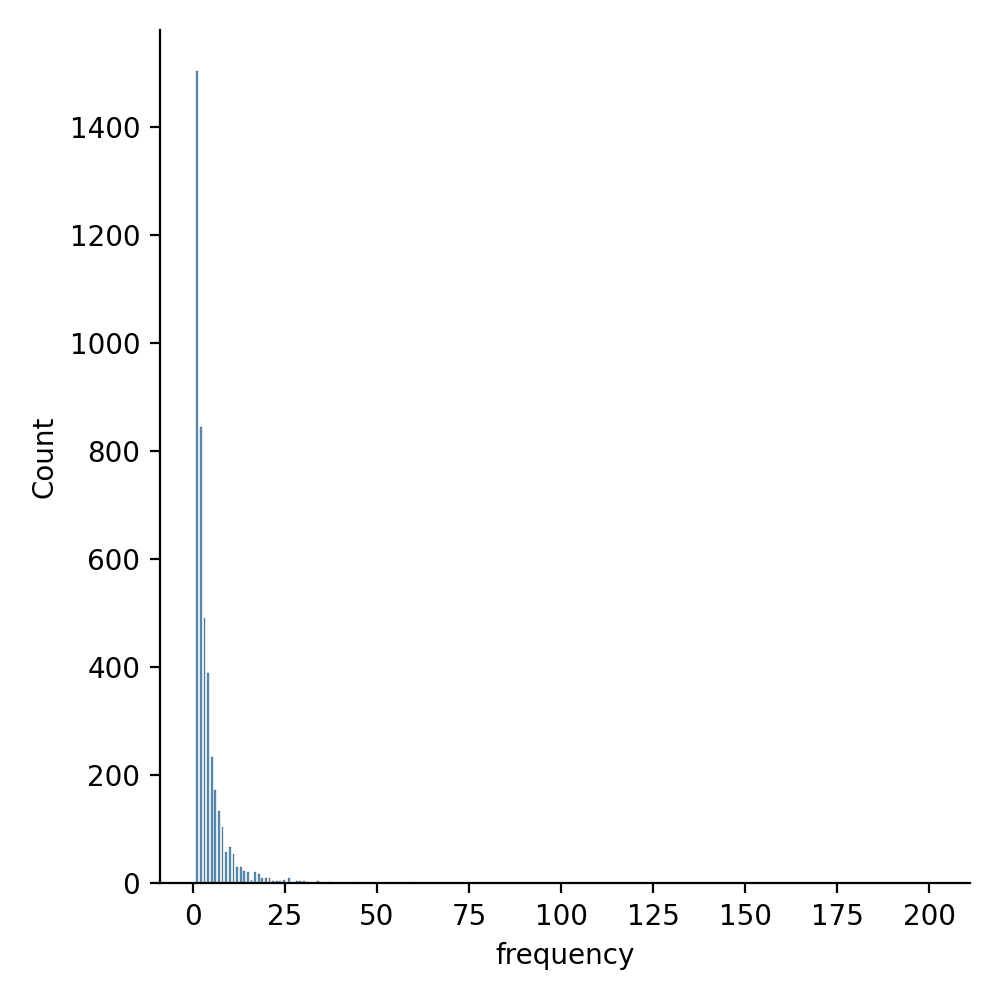

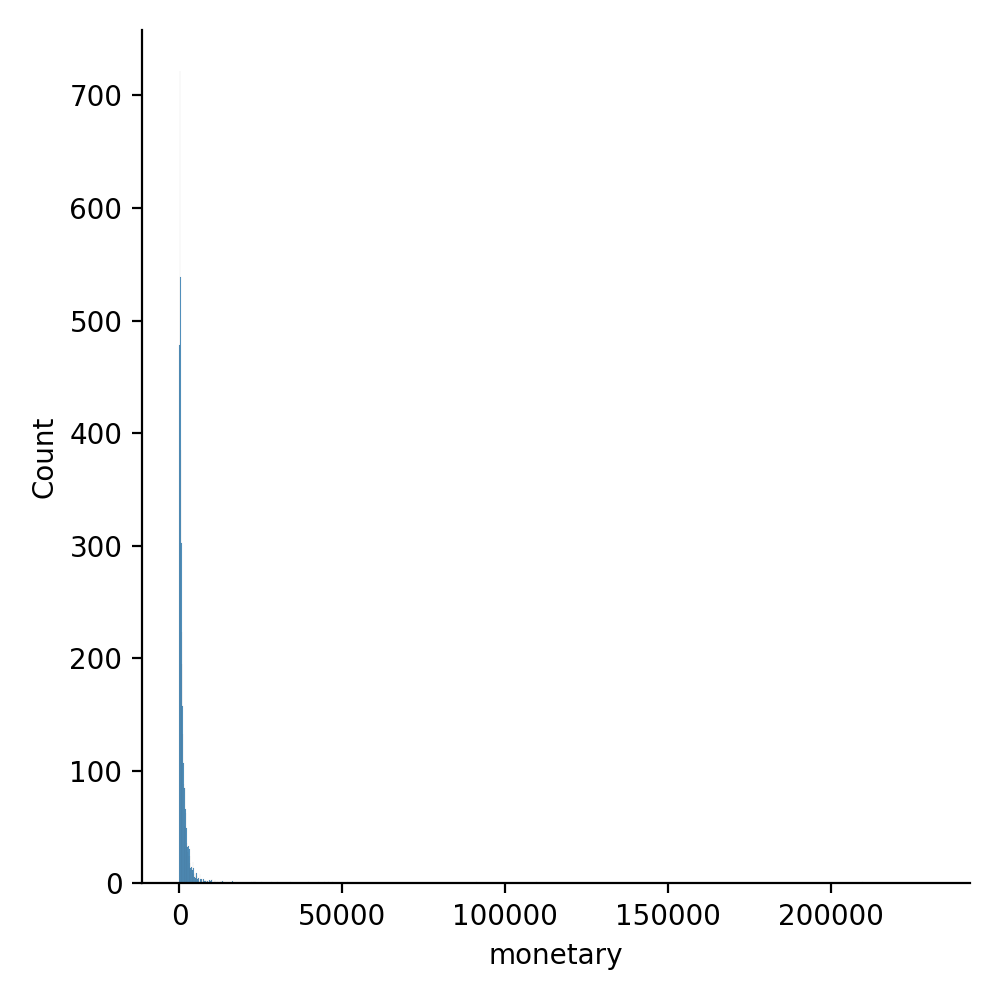

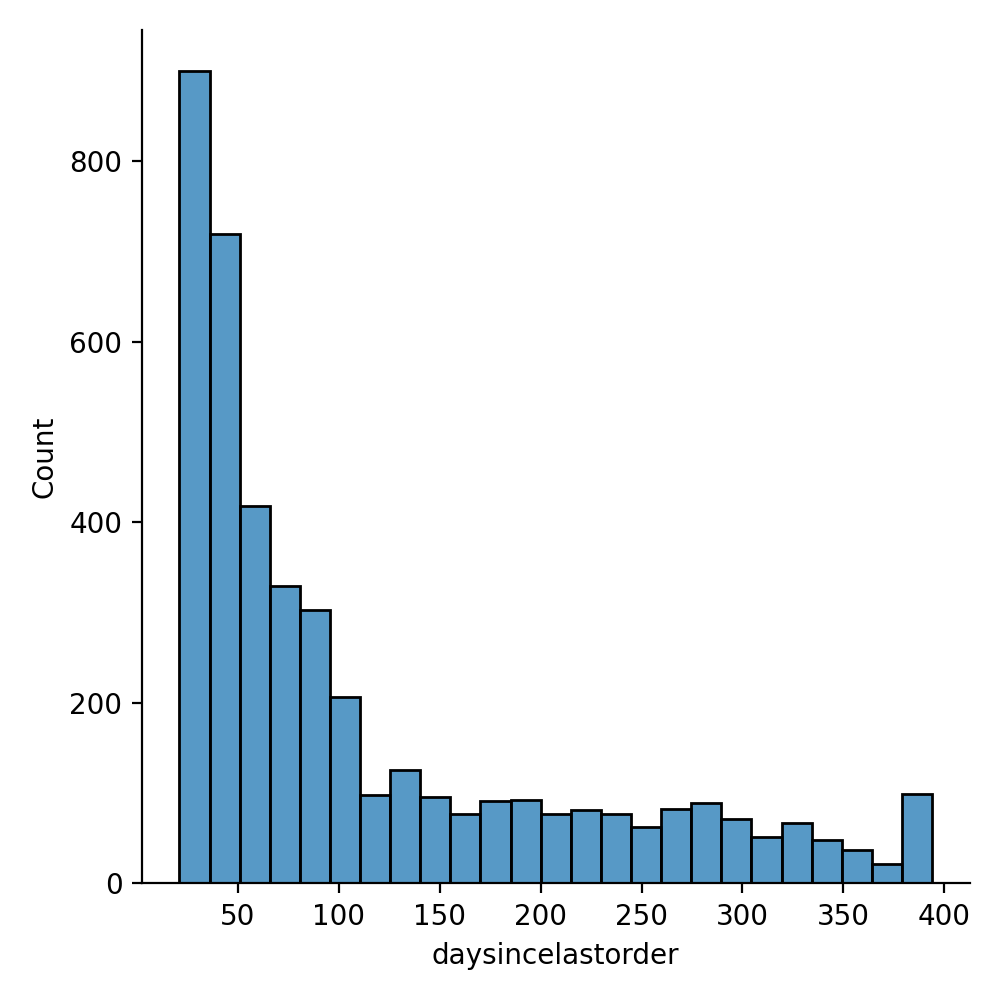

In [87]:
for col in customers_selected.columns[1:4]:
    sns.displot(data = customers_selected, x = col, kind = "hist")

In [88]:
# apply log transformation
customers_selected_log = customers_selected.copy()
for col in customers_selected.columns[1:-1]:
    customers_selected_log[col] = np.log(customers_selected[col] + 1) # add one to avoid -inf values if original value is 0

In [89]:
customers_selected_log.head()

custid  frequency   monetary  daysincelastorder  mean_prod_in_order   
0   17841   4.795791  10.393933           3.135494            3.929863  \
1   18069   1.791759   7.424720           3.871201            4.301359   
2   12714   1.791759   8.228516           3.433987            3.797734   
3   14470   1.098612   5.982298           3.496508            2.917771   
4   18158   1.098612   6.041207           3.433987            2.772589   

   mean_ordervalue  meanqtyofprodinorder  num_returns   
0         5.610078              5.022509     3.784190  \
1         5.817665              5.345201     1.098612   
2         6.620145              6.259964     0.000000   
3         5.291670              4.424847     0.000000   
4         5.350435              5.062595     0.000000   

   avg_days_between_purchases  avg_prod_value UK_Others  
0                    1.408952        1.864734        UK  
1                    4.114147        1.723517        UK  
2                    4.060443         2.90033    Others  
3                    4.930870        2.509251        UK  
4                    3.701302        2.706716        UK

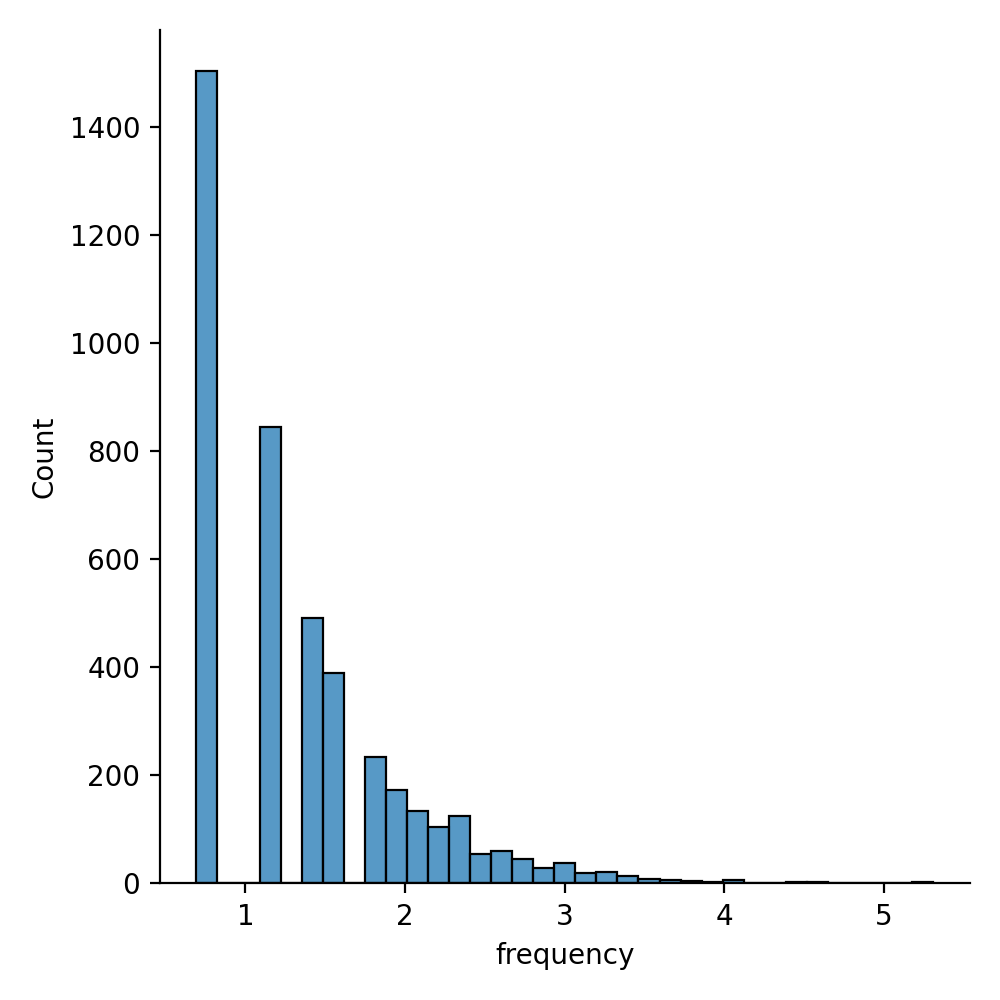

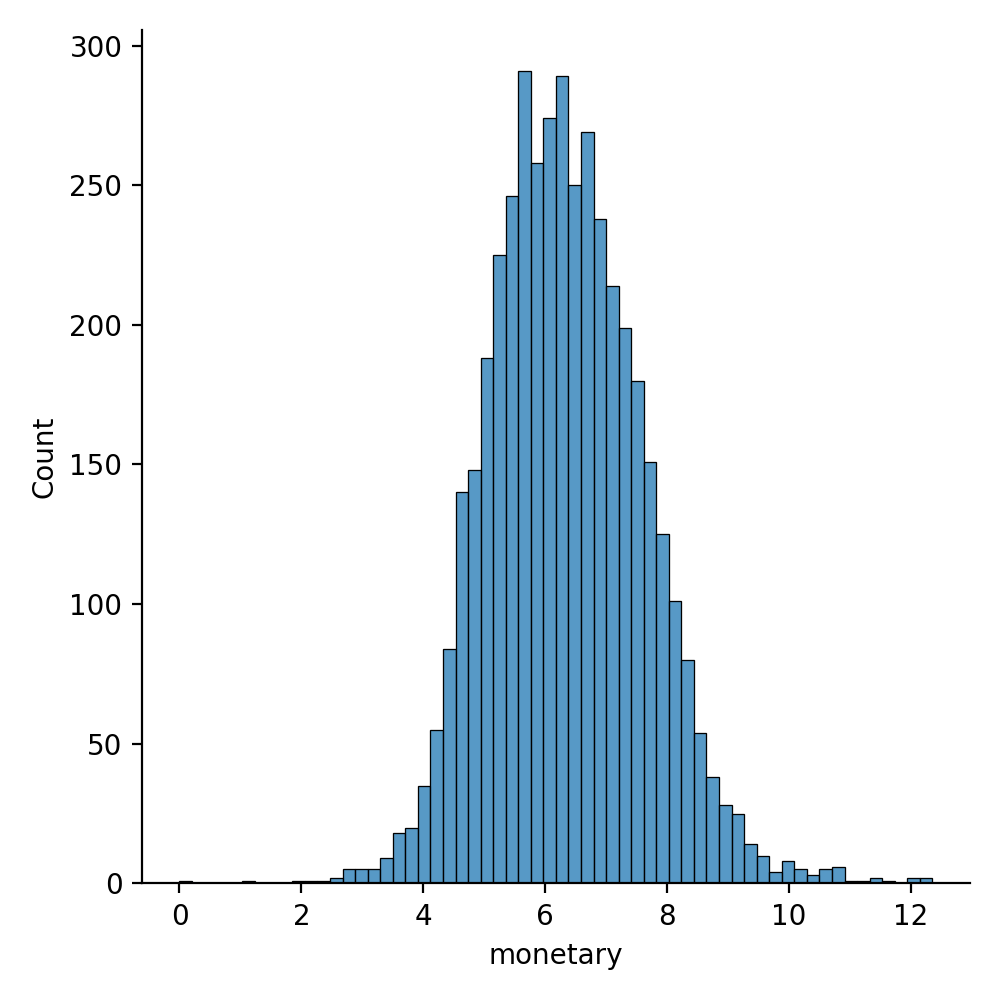

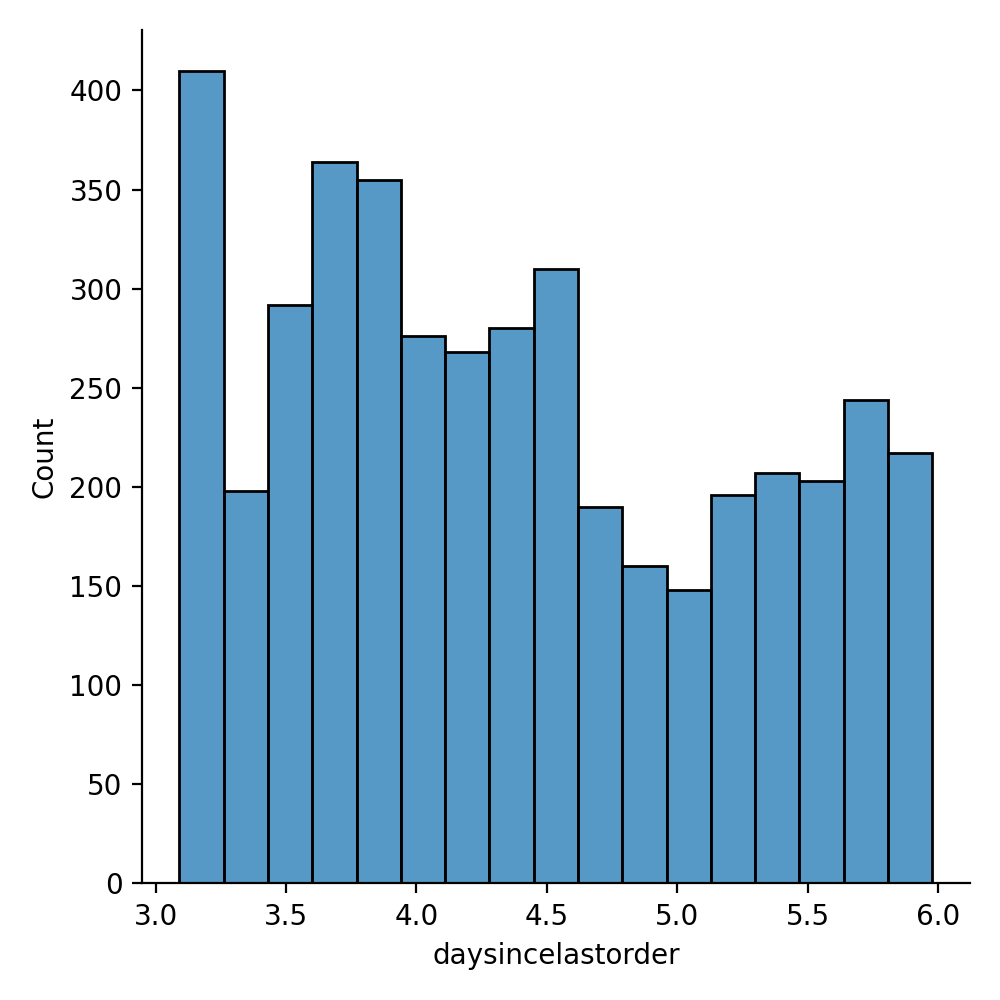

In [90]:
for col in customers_selected_log.columns[1:4]:
    sns.displot(data = customers_selected_log, x = col, kind = "hist")

In [91]:
# Apply standard scaler
from sklearn.preprocessing import StandardScaler

customers_selected_final = customers_selected_log.copy()

Scaler = StandardScaler()
customers_selected_final.iloc[:,1:-1] = Scaler.fit_transform(customers_selected_log.iloc[:,1:-1])
customers_selected_final.head()

custid  frequency  monetary  daysincelastorder  mean_prod_in_order   
0   17841   5.111234  3.204304          -1.480323            1.679606  \
1   18069   0.673612  0.853780          -0.606323            2.154099   
2   12714   0.673612  1.490090          -1.125722            1.510844   
3   14470  -0.350321 -0.288088          -1.051449            0.386911   
4   18158  -0.350321 -0.241453          -1.125722            0.201477   

   mean_ordervalue  meanqtyofprodinorder  num_returns   
0         0.256919              0.211529     6.474127  \
1         0.533132              0.568970     1.452663   
2         1.600905              1.582240    -0.601510   
3        -0.166752             -0.450493    -0.601510   
4        -0.088560              0.255932    -0.601510   

   avg_days_between_purchases  avg_prod_value UK_Others  
0                   -0.494817       -1.353344        UK  
1                    0.965394        -1.52465        UK  
2                    0.936406       -0.097093    Others  
3                    1.406246         -0.5715        UK  
4                    0.742549        -0.33196        UK

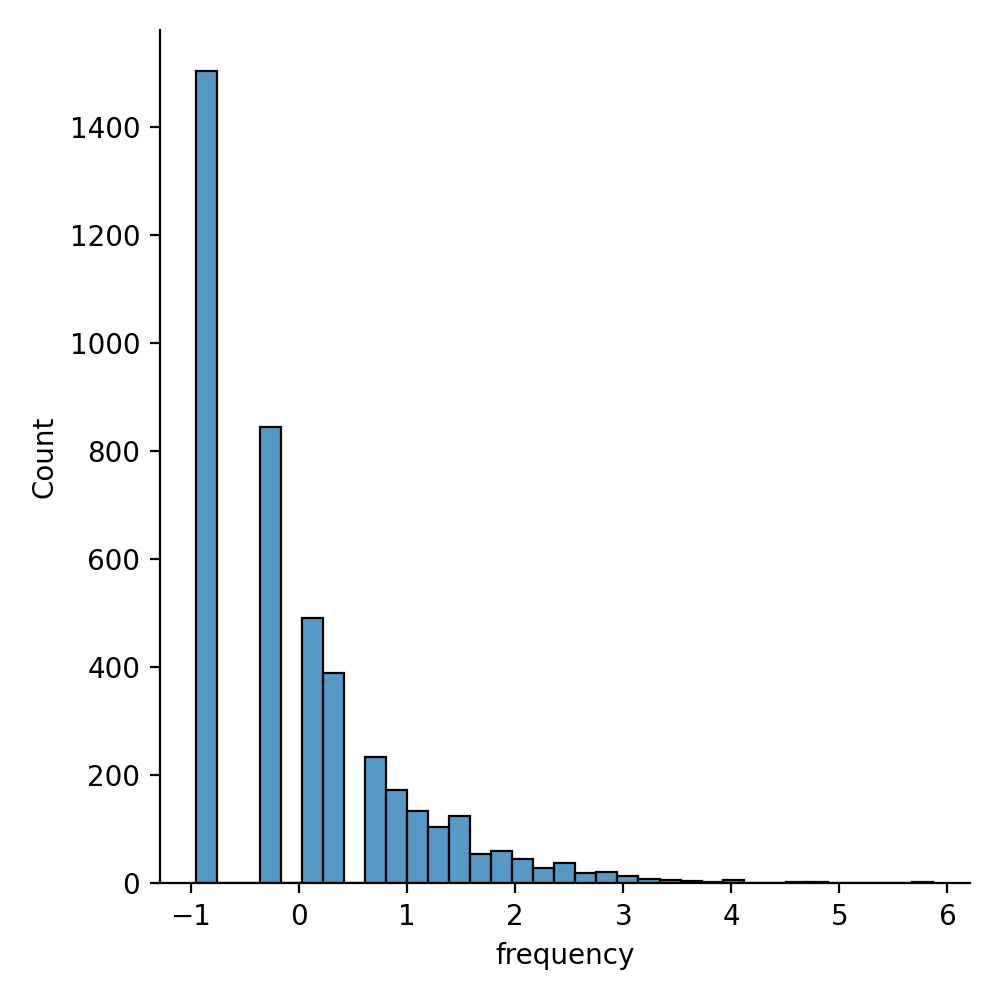

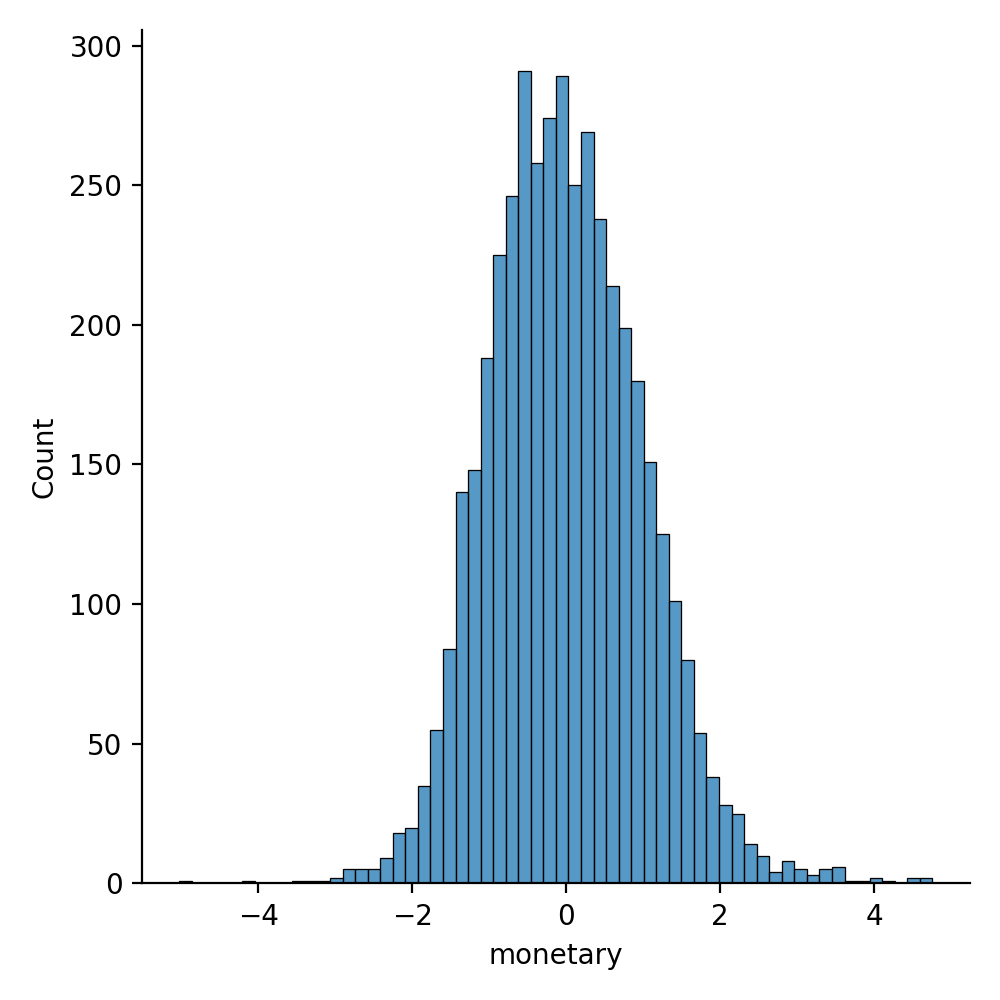

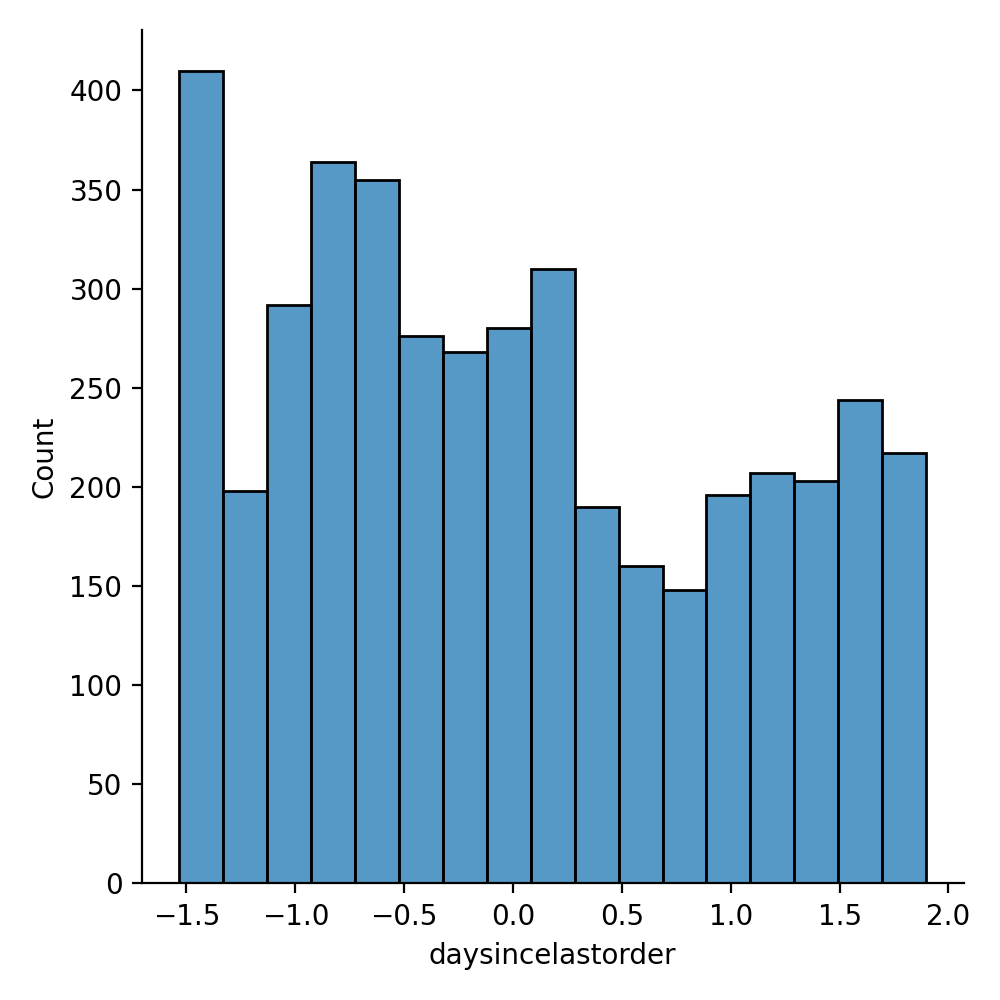

In [92]:
for col in customers_selected_final.columns[1:4]:
    sns.displot(data = customers_selected_final, x = col, kind = "hist")

### Combine segments to customer dataset

In [94]:
segments = pd.read_csv("data/customers_segmented.csv")

In [95]:
customers_full2 = pd.merge(customers_full, segments, on = "custid", how = "left")

In [96]:
customers_full2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   custid                      4318 non-null   Int64   
 1   country                     4318 non-null   object  
 2   num_orders                  4318 non-null   float64 
 3   mean_prod_in_order_x        4318 non-null   Float64 
 4   total_prod_ordered          4318 non-null   Int64   
 5   mean_ordervalue             4318 non-null   float64 
 6   total_ordervalue            4318 non-null   float64 
 7   daysincelastorder_x         4318 non-null   float64 
 8   meanqtyofprodinorder_x      4318 non-null   float64 
 9   totalqtyofprodinorder       4318 non-null   float64 
 10  num_returns                 4318 non-null   float64 
 11  mean_prod_in_return         4318 non-null   Float64 
 12  total_prod_returned         4318 non-null   Int64   
 13  mean_returnvalue  

In [97]:
customers_segments_extracted = customers_full2[["custid", "frequency_x", "monetary_x", "recency", "R", "F", "M",
                                                 "rfm_segment", "rfm_score", "mean_prod_in_order_x", "meanqtyofprodinorder_x", "_SEGMENT_"]]

In [98]:
customers_segments_extracted.columns = ["custid", "frequency", "monetary", "recency", "R", "F", "M", "rfm_segment", "rfm_score",
                                         "mean_prod_in_order", "meanqtyofprodinorder", "segment"]

In [99]:
# see distribution of customer segments
customers_segments_extracted["segment"].value_counts()

segment
4    1529
3    1091
1     974
2     723
5       1
Name: count, dtype: int64

There is only 1 customer in segment 5. For the purpose of analysing segments and customer behaviour, we will exclude the single customer in segment 5.

In [100]:
# separate customers into the different segments
segment1 = customers_segments_extracted[customers_segments_extracted["segment"] == 1]
segment2 = customers_segments_extracted[customers_segments_extracted["segment"] == 2]
segment3 = customers_segments_extracted[customers_segments_extracted["segment"] == 3]
segment4 = customers_segments_extracted[customers_segments_extracted["segment"] == 4]

# extract the custid numbers
segment1_cust = segment1["custid"].tolist()
segment2_cust = segment2["custid"].tolist()
segment3_cust = segment3["custid"].tolist()
segment4_cust = segment4["custid"].tolist()

## Market Basket Analysis

In [101]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [102]:
# only keep the purchases
purchase_list = cleaned[~cleaned["Orderno"].str.startswith("C")]

# strip spaces
purchase_list["proddesc"] = purchase_list["proddesc"].str.strip()

C:\Users\fongb\AppData\Local\Temp\ipykernel_18784\1420154754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Extract basket for segment 1 customers

In [103]:
segment1_purchase = purchase_list[purchase_list["custid"].isin(segment1_cust)]
segment1_basket = segment1_purchase.groupby(["Orderno", "proddesc"])["qty"].sum().unstack().reset_index().fillna(0).set_index("Orderno")
segment1_basket.head()

proddesc  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS   
Orderno                                                        
536371                       0.0                         0.0  \
536388                       0.0                         0.0   
536393                       0.0                         0.0   
536405                       0.0                         0.0   
536420                       0.0                         0.0   

proddesc  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD   
Orderno                                                          
536371                          0.0                        0.0  \
536388                          0.0                        0.0   
536393                          0.0                        0.0   
536405                          0.0                        0.0   
536420                          0.0                        0.0   

proddesc  12 IVORY ROSE PEG PLACE SETTINGS  12 MESSAGE CARDS WITH ENVELOPES   
Orderno                                                                       
536371                                 0.0                              0.0  \
536388                                 0.0                              0.0   
536393                                 0.0                              0.0   
536405                                 0.0                              0.0   
536420                                 0.0                              0.0   

proddesc  12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT   
Orderno                                                                        
536371                              0.0                                  0.0  \
536388                              0.0                                  0.0   
536393                              0.0                                  0.0   
536405                              0.0                                  0.0   
536420                              0.0                                  0.0   

proddesc  12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY   
Orderno                                                            
536371                            0.0                        0.0  \
536388                            0.0                        0.0   
536393                            0.0                        0.0   
536405                            0.0                        0.0   
536420                            0.0                        0.0   

proddesc  12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE WOODLAND   
Orderno                                                                       
536371                                   0.0                            0.0  \
536388                                   0.0                            0.0   
536393                                   0.0                            0.0   
536405                                   0.0                            0.0   
536420                                   0.0                            0.0   

proddesc  15 PINK FLUFFY CHICKS IN BOX  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
Orderno                                                                       
536371                             0.0                                  0.0  \
536388                             0.0                                  0.0   
536393                             0.0                                  0.0   
536405                             0.0                                  0.0   
536420                             0.0                                  0.0   

proddesc  16 PIECE CUTLERY SET PANTRY DESIGN   
Orderno                                        
536371                                   0.0  \
536388                                   0.0   
536393                                   0.0   
536405                                   0.0   
536420                                   0.0   

proddesc  2 PICTURE BOOK EGGS EASTER BUNNY  20 DOLL

In [104]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

segment1_basket_sets = segment1_basket.applymap(encode_units)
segment1_basket_sets.head()

proddesc  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS   
Orderno                                                        
536371                         0                           0  \
536388                         0                           0   
536393                         0                           0   
536405                         0                           0   
536420                         0                           0   

proddesc  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD   
Orderno                                                          
536371                            0                          0  \
536388                            0                          0   
536393                            0                          0   
536405                            0                          0   
536420                            0                          0   

proddesc  12 IVORY ROSE PEG PLACE SETTINGS  12 MESSAGE CARDS WITH ENVELOPES   
Orderno                                                                       
536371                                   0                                0  \
536388                                   0                                0   
536393                                   0                                0   
536405                                   0                                0   
536420                                   0                                0   

proddesc  12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT   
Orderno                                                                        
536371                                0                                    0  \
536388                                0                                    0   
536393                                0                                    0   
536405                                0                                    0   
536420                                0                                    0   

proddesc  12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY   
Orderno                                                            
536371                              0                          0  \
536388                              0                          0   
536393                              0                          0   
536405                              0                          0   
536420                              0                          0   

proddesc  12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE WOODLAND   
Orderno                                                                       
536371                                     0                              0  \
536388                                     0                              0   
536393                                     0                              0   
536405                                     0                              0   
536420                                     0                              0   

proddesc  15 PINK FLUFFY CHICKS IN BOX  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
Orderno                                                                       
536371                               0                                    0  \
536388                               0                                    0   
536393                               0                                    0   
536405                               0                                    0   
536420                               0                                    0   

proddesc  16 PIECE CUTLERY SET PANTRY DESIGN   
Orderno                                        
536371                                     0  \
536388                                     0   
536393                                     0   
536405                                     0   
536420                                     0   

proddesc  2 PICTURE BOOK EGGS EASTER BUNNY  20 DOLL

In [105]:
frequent_itemsets_segment1 = apriori(segment1_basket_sets.astype('bool'), min_support=0.01, use_colnames=True)
rules_segment1 = association_rules(frequent_itemsets_segment1, metric = "lift", min_threshold=1)
rules_segment1

antecedents                        consequents   
0  (GREEN REGENCY TEACUP AND SAUCER)         (REGENCY CAKESTAND 3 TIER)  \
1         (REGENCY CAKESTAND 3 TIER)  (GREEN REGENCY TEACUP AND SAUCER)   
2  (ROSES REGENCY TEACUP AND SAUCER)  (GREEN REGENCY TEACUP AND SAUCER)   
3  (GREEN REGENCY TEACUP AND SAUCER)  (ROSES REGENCY TEACUP AND SAUCER)   
4  (ROSES REGENCY TEACUP AND SAUCER)         (REGENCY CAKESTAND 3 TIER)   
5         (REGENCY CAKESTAND 3 TIER)  (ROSES REGENCY TEACUP AND SAUCER)   

   antecedent support  consequent support   support  confidence       lift   
0            0.023068            0.066321  0.012687    0.550000   8.293043  \
1            0.066321            0.023068  0.012687    0.191304   8.293043   
2            0.022491            0.023068  0.011534    0.512821  22.230769   
3            0.023068            0.022491  0.011534    0.500000  22.230769   
4            0.022491            0.066321  0.011534    0.512821   7.732441   
5            0.066321            0.022491  0.011534    0.173913   7.732441   

   leverage  conviction  zhangs_metric  
0  0.011158    2.074843       0.900182  
1  0.011158    1.208034       0.941883  
2  0.011015    2.005281       0.976991  
3  0.011015    1.955017       0.977568  
4  0.010042    1.916500       0.890708  
5  0.010042    1.183300       0.932520

### Extract basket for segment 2 customers

In [106]:
segment2_purchase = purchase_list[purchase_list["custid"].isin(segment2_cust)]
segment2_basket = segment2_purchase.groupby(["Orderno", "proddesc"])["qty"].sum().unstack().reset_index().fillna(0).set_index("Orderno")
segment2_basket.head()

proddesc  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS   
Orderno                                                        
536408                      24.0                         0.0  \
536446                       0.0                         0.0   
536526                       0.0                         0.0   
536528                       0.0                         0.0   
536531                       0.0                         0.0   

proddesc  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD   
Orderno                                                          
536408                          0.0                        0.0  \
536446                          0.0                        0.0   
536526                          0.0                        0.0   
536528                          0.0                        0.0   
536531                          0.0                        0.0   

proddesc  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS   
Orderno                                                                    
536408                             0.0                               0.0  \
536446                             0.0                               0.0   
536526                             0.0                               0.0   
536528                             0.0                               0.0   
536531                             0.0                               0.0   

proddesc  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND   
Orderno                                                                    
536408                                0.0                            0.0  \
536446                                0.0                            0.0   
536526                                0.0                            0.0   
536528                                0.0                            0.0   
536531                                0.0                            0.0   

proddesc  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL   
Orderno                                                                      
536408                                    0.0                          0.0  \
536446                                    0.0                          0.0   
536526                                    0.0                          0.0   
536528                                    0.0                          0.0   
536531                                    0.0                          0.0   

proddesc  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT   
Orderno                                                                   
536408                          0.0                                 0.0  \
536446                          0.0                                 0.0   
536526                          0.0                                 0.0   
536528                          0.0                                 0.0   
536531                          0.0                                 0.0   

proddesc  12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND   
Orderno                                                                
536408                           12.0                            0.0  \
536446                            0.0                            0.0   
536526                            0.0                            0.0   
536528                            0.0                            0.0   
536531                            0.0                            0.0   

proddesc  12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS   
Orderno                                                                   
536408                             0.0                              0.0  \
536446                             0.0                              0.0   
536526                             0.0                              0.0   
536528                             0.0                              0

In [107]:
segment2_basket_sets = segment2_basket.applymap(encode_units)
segment2_basket_sets.head()

proddesc  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS   
Orderno                                                        
536408                         1                           0  \
536446                         0                           0   
536526                         0                           0   
536528                         0                           0   
536531                         0                           0   

proddesc  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD   
Orderno                                                          
536408                            0                          0  \
536446                            0                          0   
536526                            0                          0   
536528                            0                          0   
536531                            0                          0   

proddesc  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS   
Orderno                                                                    
536408                               0                                 0  \
536446                               0                                 0   
536526                               0                                 0   
536528                               0                                 0   
536531                               0                                 0   

proddesc  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND   
Orderno                                                                    
536408                                  0                              0  \
536446                                  0                              0   
536526                                  0                              0   
536528                                  0                              0   
536531                                  0                              0   

proddesc  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL   
Orderno                                                                      
536408                                      0                            0  \
536446                                      0                            0   
536526                                      0                            0   
536528                                      0                            0   
536531                                      0                            0   

proddesc  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT   
Orderno                                                                   
536408                            0                                   0  \
536446                            0                                   0   
536526                            0                                   0   
536528                            0                                   0   
536531                            0                                   0   

proddesc  12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND   
Orderno                                                                
536408                              1                              0  \
536446                              0                              0   
536526                              0                              0   
536528                              0                              0   
536531                              0                              0   

proddesc  12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS   
Orderno                                                                   
536408                               0                                0  \
536446                               0                                0   
536526                               0                                0   
536528                               0                               

In [108]:
frequent_itemsets_segment2 = apriori(segment2_basket_sets.astype('bool'), min_support=0.01, use_colnames=True)
rules_segment2 = association_rules(frequent_itemsets_segment2, metric = "lift", min_threshold=1)
rules_segment2

antecedents   
0                 (12 PENCILS SMALL TUBE RED RETROSPOT)  \
1                       (12 PENCIL SMALL TUBE WOODLAND)   
2                       (12 PENCIL SMALL TUBE WOODLAND)   
3                         (12 PENCILS SMALL TUBE SKULL)   
4                 (12 PENCILS SMALL TUBE RED RETROSPOT)   
...                                                 ...   
3249  (POPPY'S PLAYHOUSE BATHROOM, POPPY'S PLAYHOUSE...   
3250                        (POPPY'S PLAYHOUSE BEDROOM)   
3251                     (POPPY'S PLAYHOUSE LIVINGROOM)   
3252                        (POPPY'S PLAYHOUSE KITCHEN)   
3253                       (POPPY'S PLAYHOUSE BATHROOM)   

                                            consequents  antecedent support   
0                       (12 PENCIL SMALL TUBE WOODLAND)            0.033398  \
1                 (12 PENCILS SMALL TUBE RED RETROSPOT)            0.031462   
2                         (12 PENCILS SMALL TUBE SKULL)            0.031462   
3                       (12 PENCIL SMALL TUBE WOODLAND)            0.031462   
4                         (12 PENCILS SMALL TUBE SKULL)            0.033398   
...                                                 ...                 ...   
3249  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...            0.015973   
3250  (POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOU...            0.034366   
3251  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...            0.030494   
3252  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...            0.036302   
3253  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...            0.021297   

      consequent support   support  confidence       lift  leverage   
0               0.031462  0.014521    0.434783  13.819398  0.013470  \
1               0.033398  0.014521    0.461538  13.819398  0.013470   
2               0.031462  0.010649    0.338462  10.757870  0.009659   
3               0.031462  0.010649    0.338462  10.757870  0.009659   
4               0.031462  0.013069    0.391304  12.437458  0.012018   
...                  ...       ...         ...        ...       ...   
3249            0.022265  0.010649    0.666667  29.942029  0.010293   
3250            0.013069  0.010649    0.309859  23.709963  0.010199   
3251            0.013553  0.010649    0.349206  25.766440  0.010235   
3252            0.013069  0.010649    0.293333  22.445432  0.010174   
3253            0.016941  0.010649    0.500000  29.514286  0.010288   

      conviction  zhangs_metric  
0       1.713568       0.959690  
1       1.795118       0.957771  
2       1.464069       0.936509  
3       1.464069       0.936509  
4       1.591170       0.951372  
...          ...            ...  
3249    2.933204       0.982292  
3250    1.430043       0.991912  
3251    1.515760       0.991422  
3252    1.396601       0.991439  
3253    1.966118       0.987141  

[3254 rows x 10 columns]

In [109]:
rules_segment2[(rules_segment2['lift'] >= 8) & (rules_segment2['confidence'] >= 0.6)].head(10)

antecedents                    consequents   
163  (ALARM CLOCK BAKELIKE ORANGE)    (ALARM CLOCK BAKELIKE PINK)  \
175       (ALPHABET STENCIL CRAFT)          (HAPPY STENCIL CRAFT)   
246       (DINOSAURS  WRITING SET)        (BALLOONS  WRITING SET)   
249           (KITCHEN METAL SIGN)          (BATHROOM METAL SIGN)   
251            (TOILET METAL SIGN)          (BATHROOM METAL SIGN)   
264  (BLUE HAPPY BIRTHDAY BUNTING)  (PINK HAPPY BIRTHDAY BUNTING)   
265  (PINK HAPPY BIRTHDAY BUNTING)  (BLUE HAPPY BIRTHDAY BUNTING)   
274            (BLUE POLKADOT CUP)           (PINK  POLKADOT CUP)   
275           (PINK  POLKADOT CUP)            (BLUE POLKADOT CUP)   
276            (RED RETROSPOT CUP)            (BLUE POLKADOT CUP)   

     antecedent support  consequent support   support  confidence       lift   
163            0.025653            0.046467  0.015489    0.603774  12.993711  \
175            0.017425            0.025653  0.011617    0.666667  25.987421   
246            0.016941            0.019361  0.010165    0.600000  30.990000   
249            0.015005            0.032430  0.010649    0.709677  21.883486   
251            0.022265            0.032430  0.013553    0.608696  18.769630   
264            0.038722            0.038722  0.023717    0.612500  15.817813   
265            0.038722            0.038722  0.023717    0.612500  15.817813   
274            0.024201            0.020329  0.015489    0.640000  31.481905   
275            0.020329            0.024201  0.015489    0.761905  31.481905   
276            0.021781            0.024201  0.014037    0.644444  26.628444   

     leverage  conviction  zhangs_metric  
163  0.014297    2.406537       0.947342  
175  0.011170    2.923040       0.978571  
246  0.009837    2.451597       0.984408  
249  0.010162    3.332742       0.968841  
251  0.012831    2.472679       0.968281  
264  0.022218    2.480717       0.974515  
265  0.022218    2.480717       0.974515  
274  0.014997    2.721308       0.992250  
275  0.014997    4.098354       0.988328  
276  0.013510    2.744434       0.983876

### Extract basket for segment 3

In [110]:
segment3_purchase = purchase_list[purchase_list["custid"].isin(segment3_cust)]
segment3_basket = segment3_purchase.groupby(["Orderno", "proddesc"])["qty"].sum().unstack().reset_index().fillna(0).set_index("Orderno")
segment3_basket_sets = segment3_basket.applymap(encode_units)

In [111]:
frequent_itemsets_segment3 = apriori(segment3_basket_sets.astype('bool'), min_support=0.01, use_colnames=True)
rules_segment3 = association_rules(frequent_itemsets_segment3, metric = "lift", min_threshold=1)
rules_segment3

antecedents   
0                         (ALARM CLOCK BAKELIKE GREEN)  \
1                         (ALARM CLOCK BAKELIKE IVORY)   
2                         (ALARM CLOCK BAKELIKE GREEN)   
3                          (ALARM CLOCK BAKELIKE PINK)   
4                         (ALARM CLOCK BAKELIKE GREEN)   
..                                                 ...   
205  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
206  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
207                  (ROSES REGENCY TEACUP AND SAUCER)   
208                  (GREEN REGENCY TEACUP AND SAUCER)   
209                   (PINK REGENCY TEACUP AND SAUCER)   

                                           consequents  antecedent support   
0                         (ALARM CLOCK BAKELIKE IVORY)            0.041681  \
1                         (ALARM CLOCK BAKELIKE GREEN)            0.023867   
2                          (ALARM CLOCK BAKELIKE PINK)            0.041681   
3                         (ALARM CLOCK BAKELIKE GREEN)            0.029920   
4                           (ALARM CLOCK BAKELIKE RED)            0.041681   
..                                                 ...                 ...   
205                  (GREEN REGENCY TEACUP AND SAUCER)            0.015393   
206                  (ROSES REGENCY TEACUP AND SAUCER)            0.014874   
207  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...            0.034936   
208  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...            0.029920   
209  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...            0.023867   

     consequent support   support  confidence       lift  leverage   
0              0.023867  0.011761    0.282158  11.821998  0.010766  \
1              0.041681  0.011761    0.492754  11.821998  0.010766   
2              0.029920  0.014268    0.342324  11.441129  0.013021   
3              0.041681  0.014268    0.476879  11.441129  0.013021   
4              0.046178  0.023954    0.574689  12.445133  0.022029   
..                  ...       ...         ...        ...       ...   
205            0.029920  0.010723    0.696629  23.282717  0.010262   
206            0.034936  0.010723    0.720930  20.635736  0.010203   
207            0.014874  0.010723    0.306931  20.635736  0.010203   
208            0.015393  0.010723    0.358382  23.282717  0.010262   
209            0.019976  0.010723    0.449275  22.490997  0.010246   

     conviction  zhangs_metric  
0      1.359815       0.955227  
1      1.889257       0.937794  
2      1.475011       0.952288  
3      1.831925       0.940744  
4      2.242645       0.959646  
..          ...            ...  
205    3.197670       0.972011  
206    3.458146       0.965907  
207    1.421396       0.985987  
208    1.534568       0.986568  
209    1.779518       0.978901  

[210 rows x 10 columns]

In [112]:
rules_segment3[(rules_segment3['lift'] >= 8) & (rules_segment3['confidence'] >= 0.6)].head(10)

antecedents   
21                    (PINK REGENCY TEACUP AND SAUCER)  \
25                   (GREEN REGENCY TEACUP AND SAUCER)   
187                   (PINK REGENCY TEACUP AND SAUCER)   
202               (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
205  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
206  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   

                               consequents  antecedent support   
21       (GREEN REGENCY TEACUP AND SAUCER)            0.023867  \
25       (ROSES REGENCY TEACUP AND SAUCER)            0.029920   
187      (ROSES REGENCY TEACUP AND SAUCER)            0.023867   
202  (WOODEN HEART CHRISTMAS SCANDINAVIAN)            0.017382   
205      (GREEN REGENCY TEACUP AND SAUCER)            0.015393   
206      (ROSES REGENCY TEACUP AND SAUCER)            0.014874   

     consequent support   support  confidence       lift  leverage   
21             0.029920  0.014874    0.623188  20.828181  0.014160  \
25             0.034936  0.019976    0.667630  19.110084  0.018930   
187            0.034936  0.015393    0.644928  18.460253  0.014559   
202            0.019111  0.010809    0.621891  32.540915  0.010477   
205            0.029920  0.010723    0.696629  23.282717  0.010262   
206            0.034936  0.010723    0.720930  20.635736  0.010203   

     conviction  zhangs_metric  
21     2.574442       0.975265  
25     2.903584       0.976901  
187    2.717935       0.968956  
202    2.594193       0.986415  
205    3.197670       0.972011  
206    3.458146       0.965907

### Extract basket for segment 4

In [113]:
segment4_purchase = purchase_list[purchase_list["custid"].isin(segment4_cust)]
segment4_basket = segment4_purchase.groupby(["Orderno", "proddesc"])["qty"].sum().unstack().reset_index().fillna(0).set_index("Orderno")
segment4_basket_sets = segment4_basket.applymap(encode_units)

In [114]:
frequent_itemsets_segment4 = apriori(segment4_basket_sets.astype('bool'), min_support=0.01, use_colnames=True)
rules_segment4 = association_rules(frequent_itemsets_segment4, metric = "lift", min_threshold=1)
rules_segment4

antecedents   
0                      (PAINTED METAL PEARS ASSORTED)  \
1                     (ASSORTED COLOUR BIRD ORNAMENT)   
2                       (BLUE HAPPY BIRTHDAY BUNTING)   
3                       (PINK HAPPY BIRTHDAY BUNTING)   
4                   (CANDLEHOLDER PINK HANGING HEART)   
..                                                ...   
69  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
70  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
71                  (ROSES REGENCY TEACUP AND SAUCER)   
72                  (GREEN REGENCY TEACUP AND SAUCER)   
73                   (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents  antecedent support   
0                     (ASSORTED COLOUR BIRD ORNAMENT)            0.025340  \
1                      (PAINTED METAL PEARS ASSORTED)            0.076019   
2                       (PINK HAPPY BIRTHDAY BUNTING)            0.017628   
3                       (BLUE HAPPY BIRTHDAY BUNTING)            0.018729   
4                (WHITE HANGING HEART T-LIGHT HOLDER)            0.016893   
..                                                ...                 ...   
69                  (GREEN REGENCY TEACUP AND SAUCER)            0.014690   
70                  (ROSES REGENCY TEACUP AND SAUCER)            0.019464   
71  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...            0.030114   
72  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...            0.031216   
73  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...            0.024238   

    consequent support   support  confidence       lift  leverage  conviction   
0             0.076019  0.016526    0.652174   8.579080  0.014600    2.656445  \
1             0.025340  0.016526    0.217391   8.579080  0.014600    1.245399   
2             0.018729  0.012853    0.729167  38.931781  0.012523    3.623153   
3             0.017628  0.012853    0.686275  38.931781  0.012523    3.131312   
4             0.099155  0.011385    0.673913   6.796538  0.009709    2.762590   
..                 ...       ...         ...        ...       ...         ...   
69            0.031216  0.012119    0.825000  26.429118  0.011660    5.535911   
70            0.030114  0.012119    0.622642  20.676254  0.011533    2.570198   
71            0.019464  0.012119    0.402439  20.676254  0.011533    1.640897   
72            0.014690  0.012119    0.388235  26.429118  0.011660    1.610603   
73            0.017628  0.012119    0.500000  28.364583  0.011692    1.964745   

    zhangs_metric  
0        0.906405  
1        0.956121  
2        0.991797  
3        0.992911  
4        0.867521  
..            ...  
69       0.976508  
70       0.970525  
71       0.981183  
72       0.993165  
73       0.988709  

[74 rows x 10 columns]

In [115]:
rules_segment4[(rules_segment4['lift'] >= 8) & (rules_segment4['confidence'] >= 0.6)].head(10)

antecedents   
0                      (PAINTED METAL PEARS ASSORTED)  \
2                       (BLUE HAPPY BIRTHDAY BUNTING)   
3                       (PINK HAPPY BIRTHDAY BUNTING)   
8                   (GREEN REGENCY TEACUP AND SAUCER)   
9                    (PINK REGENCY TEACUP AND SAUCER)   
51                   (PINK REGENCY TEACUP AND SAUCER)   
58                 (SET OF 6 SNACK LOAF BAKING CASES)   
59                 (SET OF 12 MINI LOAF BAKING CASES)   
68  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...   
69  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   

                           consequents  antecedent support   
0      (ASSORTED COLOUR BIRD ORNAMENT)            0.025340  \
2        (PINK HAPPY BIRTHDAY BUNTING)            0.017628   
3        (BLUE HAPPY BIRTHDAY BUNTING)            0.018729   
8     (PINK REGENCY TEACUP AND SAUCER)            0.031216   
9    (GREEN REGENCY TEACUP AND SAUCER)            0.024238   
51   (ROSES REGENCY TEACUP AND SAUCER)            0.024238   
58  (SET OF 12 MINI LOAF BAKING CASES)            0.018362   
59  (SET OF 6 SNACK LOAF BAKING CASES)            0.019464   
68    (PINK REGENCY TEACUP AND SAUCER)            0.017628   
69   (GREEN REGENCY TEACUP AND SAUCER)            0.014690   

    consequent support   support  confidence       lift  leverage  conviction   
0             0.076019  0.016526    0.652174   8.579080  0.014600    2.656445  \
2             0.018729  0.012853    0.729167  38.931781  0.012523    3.623153   
3             0.017628  0.012853    0.686275  38.931781  0.012523    3.131312   
8             0.024238  0.019464    0.623529  25.725312  0.018707    2.591868   
9             0.031216  0.019464    0.803030  25.725312  0.018707    4.918444   
51            0.030114  0.014690    0.606061  20.125647  0.013960    2.462019   
58            0.019464  0.012119    0.660000  33.909057  0.011762    2.883930   
59            0.018362  0.012119    0.622642  33.909057  0.011762    2.601340   
68            0.024238  0.012119    0.687500  28.364583  0.011692    3.122438   
69            0.031216  0.012119    0.825000  26.429118  0.011660    5.535911   

    zhangs_metric  
0        0.906405  
2        0.991797  
3        0.992911  
8        0.992097  
9        0.985002  
51       0.973918  
58       0.988663  
59       0.989774  
68       0.982056  
69       0.976508